# Jasssummarizer - The story
---
# 01) Introduction - The problem

## General
After having a nice "Swiss Jass" game played, you must calculate the points of the cards you just won. Some players are really fast in counting and other use endless time to count them. Wouldn't it be nice if we could just automatically count it by dropping them in front of a camera and tell them which kind of "trumpf" you just played?  
The game has different modes to play. Here is a list of the most common used modes:
* Trumpf Eicheln (counts regular)
* Trumpf Rosen (counts regular)
* Trumpf Schellen (counts double wise)
* Trumpf Schilten (counts double wise)
* Topdown (counts triple wise)
* Downup (counts triple wise)

To count the point on the cards check the following table

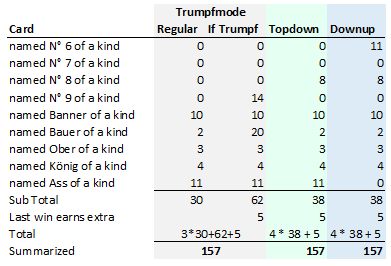

## About the cards
* the set of cards holds 36 different cards
* there are 4 different groups of cards
  * Eicheln
  * Schellen
  * Schilten
  * Rosen
* each group has 9 cards which are ordered from
  * named N° 6 of a kind
  * named N° 7 of a kind
  * named N° 8 of a kind
  * named N° 9 of a kind
  * named Banner of a kind
  * named Bauer of a kind
  * named Ober of a kind
  * named König of a kind
  * named Ass of a kind
  
<table style="border: solid #fff;horizontal-align:left;">
<!--  Website to generate base63 stream : https://www.base64-image.de/-->    
    <tr style="vertical-align:top">
        <td>Eicheln</td>
        <td>Schellen</td>
        <td>Schilten</td>
        <td>Rosen</td>          
    </tr>
    <tr style="vertical-align:top">
        <td>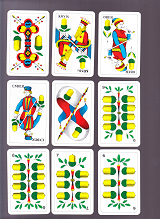</td>
        <td>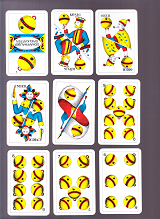</td>
        <td>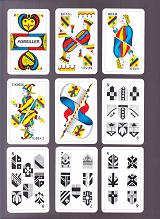</td>
        <td>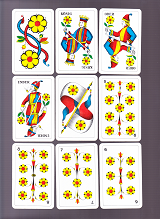</td>          
    </tr>    
</table>  


---
# 02) the data

## (a) Clear overview of my data

The data I need are the images that represent the Swiss Jass card set. Since there is no public data set for this, I have to fulfill this requirement myself. I assume I can start with a set of around 30-40 images per card. This results in a total of around 1400 images.

### Images scanning
* To produce as much as possible images for each card representation, 
  1. I'm going to take a video ([MP4](https://de.wikipedia.org/wiki/MP4)) from each card. I'm going to move each card in front of the lenses from the left to the right.
  2. after the video has been taken, it will be separated into frames. 
  3. all the frames get the card identifier from his representation within its image filename.
* **Resolution**
  * The resolution of the source is 1920 x 1080 pixels for the mobile device
  * The resolution of the source is 640 x 480 pixels for the webcam device
* **Quality**
  * the quality is varying, because of the movement during recording
  * but in general, there are no other objects on the picture except the background
* **Flexibility**
  * To get a first feeling of the data representation, I will just work with the card set from one producer
  * If needed, we can add another jass card producer which has some small differences in his layout/style
  
### card identification

A card can be identified with his **type** which is
* Eicheln, Schellen, Schilten or Rosen  => (A,B,C,D)

and on the other hand on his **value**
* N6, N7, N8, N9, Banner, Bauer, Ober, König, Ass => (0,1,2,3,4,5,6,7,8)


### Features
image

### Target  
cardType+cardValue

---
## (b) Plan to manage and process the data
### Data Preparation 01

We need many images, representing each class of card. To achieve this Goal I'm creating a movie of each card. Each movie is around 10" and during this time the card moves in front of the camera. The result will be a [MP4 File](https://de.wikipedia.org/wiki/MP4).

### How has the movie been taken
I made 2 runs on capturing movies with my Samsung S8. Please note that the card itself is using a photo glue in the back to be fixed on a geo triangle or paper stripe.
1. The first run was on 7.1 and the setup was not perfect. Everything went well. But it was a bad decision to have a wooden table as background. To improve it I decided later to run another scan.  
![Data Scan I](./images/diverse/datascan_i_kl.jpg)
2. The second run was made on the 22.1. Similar to the handy scan it was taken in front of the webcam. I used a special jupyter notebook for this type of scan. To switch to another card, I had to press space as it was defined by me in the jupyter notebook.  
![Data Scan II](./images/diverse/webbcamscan_ii_kl.jpg)
2. The third run was on 25.1. At this time I used a black background. I also payed attention to have a better angle to the lying card.  
![Data Scan III](./images/diverse/datascan_iii_kl.jpg)

### Dataextraction for Datascan I & III (Movie related)

The next cell extracts all frames within a Movie into JPG images. Because of the big resolution of the movie (Full HD), we are going to scale the image by 40%. The generated JPG are stored in the filesystem.  

> Please Note: that we don't have to do anything on DataScan II, because they are already in the JPG format from the webcam capture.


In [1]:
import JassSummarizer as js
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from tqdm import tqdm
import shutil
import os
from enum import Enum
import random
import time
import datetime
import re
import cv2                                                              # computer vision python library see 

In [2]:
# define multiple scan input paths
pathList= [r".\images\02_data_preparation\datascan_i",r".\images\02_data_preparation\datascan_iii"]
OUTPUTPATH= r".\images\02_data_preparation\train_"
# iterate trough pathList
for path in pathList:
    setName=path.split("\\")[-1]
    outputPath=OUTPUTPATH+setName
    
    # generate a fileList of desired mp4 files
    fileList = [os.path.join(dp, f) for dp, dn, filenames in os.walk(path) for f in filenames if os.path.splitext(f)[1] == '.mp4']

    # check availability of outputpath .. create if necessary
    if not os.path.exists(outputPath):
        os.mkdir(outputPath)

    if not os.path.exists(r".\images\02_data_preparation\train_datascan_iii\A0\A0_00000.jpg"):
        # iterate trough all movies
        for movie in fileList:
            cardId=movie.replace(path,"")[1:3]                                  # store the cardId from mvoviename the first 2 chars
            outputPathCard=os.path.join(outputPath,cardId)                      # generate outputPath per cardId
            if not os.path.exists(outputPathCard):                              # check if already there
                os.mkdir(outputPathCard)                                        # create if missing

            vidcap = cv2.VideoCapture(movie)                                    # open videostream
            success,image = vidcap.read()                                       # read first frame
            count = 0
            while success:
              outFile=os.path.join(outputPathCard,cardId+"_"+str(count).zfill(5)+".jpg")
              cv2.imwrite(outFile, js.scaleImage(image,40))                     # save frame as JPEG file with scaleFactor 40%
              success,image = vidcap.read()                                     # red next frame      
              count += 1
            #print(f"{cardId} {count}")                                          # print frame cout per cardId
            vidcap.release()                                                    # release videostream    




### Datascan reorganisation Datascan II (Webcam Capturing)
To put the datascan II to the same layout as the datascan I & III, we need to copy them to the appropriate folder and create the cardId folder structure.

In [3]:
path=r".\images\02_data_preparation\datascan_ii"
setName=path.split("\\")[-1]
outputPath=OUTPUTPATH+setName
# check availability of outputpath .. create if necessary
if not os.path.exists(outputPath):
    os.mkdir(outputPath)

if not os.path.exists(r".\images\02_data_preparation\train_datascan_ii\D8\D8_000033.jpg"):
    
    # generate a fileList of desired jpg files
    fileList = [os.path.join(dp, f) for dp, dn, filenames in os.walk(path) for f in filenames if os.path.splitext(f)[1] == '.jpg']

    for file in fileList:
        cardId=file.replace(path,"")[1:3]                                           # store the cardId from mvoviename the first 2 chars 
        outputPathCard=os.path.join(outputPath,cardId)                              # generate outputPath per cardId
        if not os.path.exists(outputPathCard):                                      # check if already there
            os.mkdir(outputPathCard)                                                # create if missing
        shutil.copyfile(file,os.path.join(outputPathCard,file.split("\\")[-1]))
    

### Statistics
The next cell shows some statistical information about the data.
* It shows for each scan a table Matrix with the count of Images. The lowest value is highlighted in yellow
* It shows a histogram for each datascan and its distribution of card type


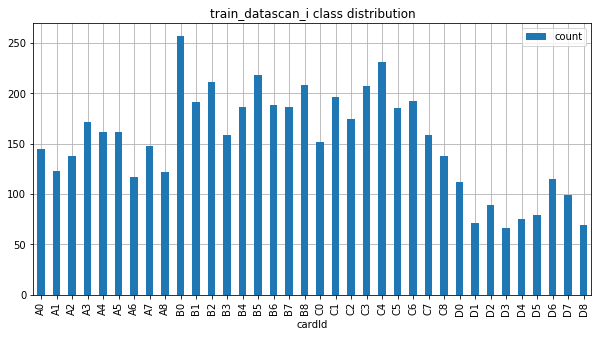

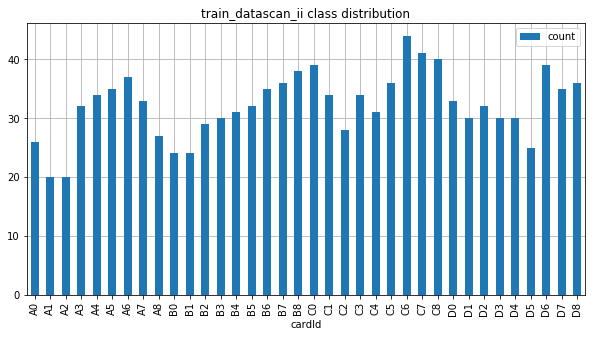

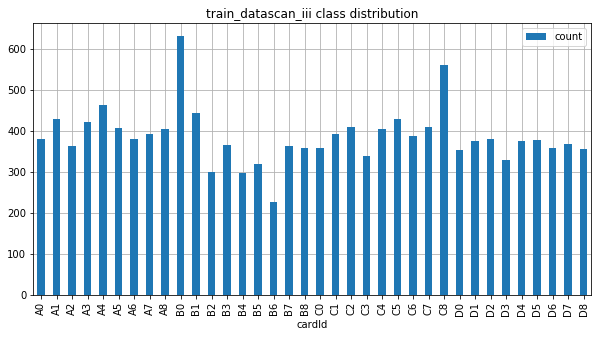

In [4]:
# define multiple scan input paths
pathList= [r".\images\02_data_preparation\train_datascan_i",r".\images\02_data_preparation\train_datascan_ii",r".\images\02_data_preparation\train_datascan_iii"]
# iterate trough pathList
for path in pathList:
    setName=path.split("_")[-1]
    display(HTML(f'<h3>Dataset {setName.upper()}</h3>'))


    fileList = [os.path.join(dp, f) for dp, dn, filenames in os.walk(path) for f in filenames if os.path.splitext(f)[1] == '.jpg']

    cardHistCount=np.zeros([1, len(js.JassCN2)],int).flatten()                          # define an emppty array with the length of the different card classes
    for item in fileList:                                                               # loop trough
        fName=item.split("\\")[-1]                                                      # get file name
        cardId=js.JassCN2[fName[0:2]].value                                             # parse cardId
        cardHistCount[cardId]=cardHistCount[cardId]+1                                   # increment cardId counter

    histogram=pd.DataFrame(cardHistCount,columns=["count"])                             # put data in pandas Dataframe for easy drawing
    histogram["cardId"]=js.JassCN2._member_names_                                       # add column with all card types
    histogram["a"]=histogram["cardId"].str.slice(start=1,stop=2)                        # create column a to store card names
    histogram["b"]=histogram["cardId"].str.slice(stop=1)                                # create column b to store card type

    t=pd.pivot_table(histogram,values="count",index=["a"],columns=["b"])                # create pivot representation
    t.columns=js.Jassmode._member_names_[0:4]                                           # include the types into columns
    t["type"]=js.JassCN._member_names_                                                  # include the card names into index
    t=t.set_index("type")                                                               # activate index
    t=t.style.apply(js.highlight_min, color='yellow', axis=None)                        # highlight lowest value
    display(t)

    histogram.plot.bar(x="cardId",y="count",grid=True,figsize=(10,5),title=path.split("\\")[-1]+" class distribution",zorder=10)


## Data Preparation 02 (Webcam Scanner)

The Datascan II set was done with a webcam. The main idea is to use the same device for a training set, as will be used in the final step during capturing the dropping cards. We may profit from a similar lightning scene as was used during training.  

### Dataextraction for Datascan II (Webcam)

The next cell shows the step that was used for the scan.

> <u>NOTE 1</u>: Every 800 milliseconds the computer is saving the current card to the disk. The card itself is slightly moved and turned for a while. If enough scans are recorded, we push the space key to step to the next cardId. The current cardId is also displayed in the frame to give feedback to the operator which card should be shown under the webcam. After all cards are done you can exit with escape.  
After scanning you can easily do a visual check in the output directory and remove scan's which to not fulfill the requirements of a nice scan.

> <u>NOTE 2</u>: The next cell includes the function **js.analyzeScan(frame)** within the helper library [JassSummarizer.py](JassSummarizer.py) . This function is explained in more detail in the next paragraph.


In [5]:
iCnt=pCnt=0                                                             # enumerator indexer for all cards
cap = cv2.VideoCapture(0)                                               # webcam capture method 0 primary cam, 1 secondary cam
_, frame = cap.read()                                                   # take frame
if frame is None or 1==1:                                                       # could we read data from webcam
    print("could not find webcam. Probably there is none connected")    # if not display info message
else:
    while(1):                                                               # loop until esc key
        # Take each frame
        _, frame = cap.read()                                               # take frame
        frameOrg,mask,img_rect,res,crop_img,d = js.analyzeScan(frame)       # analyze image and receive diffrent result images including boundingbox dimension

        theCardText=js.jassCardName(js.JassCN2(pCnt).name)                  # current cardId text to inform operator about current cardIdentification
        cv2.putText(frame,theCardText, (40,40), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,0))           # write text in image
        cv2.imwrite(f"C:/temp/JassSummarizer/{js.JassCN2(pCnt).name}_{iCnt:06d}.jpg", res)          # save scan to corresponding path (using tempory path for convieniemce)

        cv2.imshow('capture',res)                                           # show captured image
        cv2.imshow('frame',frame)                                           # show scan with informations
        cv2.imshow('mask',np.array(mask))                                   # show mask
        k = cv2.waitKey(800) & 0xFF                                         # wait 800 milliseconds for a keystroke or continue
        iCnt=iCnt+1                                                         # increment image number 
        if k == 32:                                                         # on space skip to next CardId
            pCnt=pCnt+1                                                     # increment cardId
            iCnt=0                                                          # start on 0 for new cardId
        if k == 27:                                                         # exit on escape
            break        
    cv2.destroyAllWindows()                                                 # destroy added windows

could not find webcam. Probably there is none connected


### Explanation of js.analyzeScan(frame) function
With the help of the Open Computer Vision library, I will use different technics to find the region of interest. 
  * Grayscale blurring
  * building a mask by thresholding specific colors/shadings
  * combining contour finding  with area selection
  * My algorithm is described in the [JassSummarizer.py](JassSummarizer.py) helper module with the name **analyzeScan(frame, kThreshold = 0.4)**
* This algorithm will also be used on the final step, when the computer needs to predict the cards (in front of the webcam)

#### Output parameters

* **frameOrg** Is the image which is used as input for the analyseScan function
* **mask** Is the mask which was found on the input data. It respects the threshold slider which can optimize current light conditions
* **img_rect** gives feedback to the user what has been found on the picture and draws the bounding box around it
* **res** Is the optimized input where the background around the card is full black. This was determined by the mask
* **crop_img** is the optimized frame where the full card is visible only



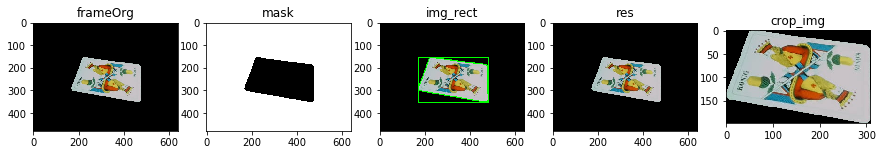

x:170 y:156 width:307 height:197


In [6]:
# load an example image
myImage=cv2.imread(r".\images\02_data_preparation\datascan_ii\A7_000013.jpg",cv2.IMREAD_COLOR)
frameOrg,mask,img_rect,res,crop_img,d=js.analyzeScan(myImage,0.5)       # call anlyzeScan function and save results
titles=["frameOrg","mask","img_rect","res","crop_img"]                  # name the paramters to display it on charts
visualCheck= True                                                       # switch to show or not visualization
if visualCheck:                                                         # check
    data=js.analyzeScan(frameOrg)                                       # do it again .. was copied from frontend juypter notebook
    display(HTML("<h3>analyzeImage result check</h3>"))                      # write title
    fig=plt.figure(figsize=(15,15))                                     # prepare figure size
    i=col=1                                                             # initialize variables
    for item in data[0:-1]:                                             # iterate only image parameters
        temp=cv2.cvtColor(item,cv2.COLOR_BGR2RGB)                       # justify cv color channels
        fig.add_subplot(1, 5, i)                                        # add sublot on index i
        plt.title(titles[i-1])                                          # set title
        plt.imshow(temp)                                                # show parameter within chart
        i=i+1                                                           # increase index
    plt.show()                                                          # show chart
print(f"x:{d[0]} y:{d[1]} width:{d[2]} height:{d[3]}")                  # explain integer parameters


## Data Preparation 03

On Data Preparation step 03, I'm generating synthetic image data by rotating them from -90 to 90 degree. This results are 180 * 36 images equal to around 6400 images. This image set is saved as **Datascan iv**

### Datascan iv
The main function js.rotate_image is defines in the JassSummarizer.py helper library.



In [7]:
iCnt=0
outputPath=r".\images\02_data_preparation\train_datascan_iv"                        # initialize path
if not os.path.exists(outputPath):                                                  # check availability of outputpath
    os.mkdir(outputPath)                                                            # create if necessary
if not os.path.exists(r".\images\02_data_preparation\train_datascan_iv\D8\D8_006479.jpg"):
    for cardType in "a,b,c,d".split(","):                                           # iterate for each card type
        path=r".\\images\\"+cardType                                                # construct desired input path
        fileList = [os.path.join(dp, f) for dp, dn, filenames in os.walk(path) for f in filenames if os.path.splitext(f)[1] == '.jpg']
        with tqdm(total=len(fileList)) as pbar:                                     # visualize progress
            for file in fileList:                                                   # iterate trough all files found 
                myImage=cv2.imread(file,cv2.IMREAD_COLOR)                           # read image
                frameOrg,mask,img_rect,res,original,d=js.analyzeScan(myImage,0.5)   # call analyzeScan
                cardType=file.split("\\")[-1][0:2].upper()                          # get target cardType
                outputPathCard=os.path.join(outputPath,cardType)                    # prepare outputpath
                if not os.path.exists(outputPathCard):                              # check if already there
                    os.mkdir(outputPathCard)                                        # create if not there
                for angle in range(-90,90,1):                                       # loop trough the angles
                    bigImage=np.zeros((1104*3,724*3,3),"uint8")                     # build superset image to make sure it gets fit during rotating
                    myImage=original.copy()                                         # copy original data
                    bigImage[1104:(1104+myImage.shape[0]), 724:(724+myImage.shape[1])] = myImage
                    result=js.rotate_image(bigImage,angle)                          # rotate image on angle
                    frameOrg,mask,img_rect,res,crop_img,d=js.analyzeScan(result,0.4)       # crop image
                    outFilename=os.path.join(outputPathCard,f"{cardType}_{iCnt:06d}.jpg")  # generate output filename
                    cv2.imwrite(outFilename, js.scaleImage(crop_img,40))            # scale & save scan to corresponding path (using tempory path for convenience)
                    iCnt=iCnt+1                                                     # increase counter
                pbar.update(1)                                                      # update progres bar

### Datascan v

On the 11.03.2021 the datascan_ii dataset has been enhanced with synthetic rotation for every 3° from -90° to 90°. This calculation and image generation has **taken about 4.5 hours**. Finally the datascan_v has now about 69'360 images.

>Note: There is an if expression which prevents the next time consuming step. If you have to or want to generate the images, please correct the expression to; **if 1==1:**


In [8]:
# if you really want to generate the images, edit the next line to : 1==1
if 1==2:
    iCnt=0
    pathList= [r".\images\02_data_preparation\datascan_ii"]
    OUTPUTPATH= r".\images\02_data_preparation\train_datascan_v"
    # iterate trough pathList
    for path in pathList:
        setName=OUTPUTPATH[-1]
        outputPath=OUTPUTPATH
        if not os.path.exists(outputPath):                                                  # check availability of outputpath
            os.mkdir(outputPath)                                                            # create if necessary

        # generate a fileList of desired mp4 files
        fileList = [os.path.join(dp, f) for dp, dn, filenames in os.walk(path) for f in filenames if os.path.splitext(f)[1] == '.jpg']

        with tqdm(total=len(fileList)) as pbar:                                     # visualize progress
                for file in fileList:                                                   # iterate trough all files found 
                    myImage=cv2.imread(file,cv2.IMREAD_COLOR)                           # read image
                    frameOrg,mask,img_rect,res,original,d=js.analyzeScan(myImage,0.5)   # call analyzeScan
                    cardType=file.split("\\")[-1][0:2].upper()                          # get target cardType
                    outputPathCard=os.path.join(outputPath,cardType)                    # prepare outputpath
                    if not os.path.exists(outputPathCard):                              # check if already there
                        os.mkdir(outputPathCard)                                        # create if not there
                    for angle in range(-90,90,3):                                       # loop trough the angles
                        bigImage=np.zeros((1104*3,724*3,3),"uint8")                     # build superset image to make sure it gets fit during rotating
                        myImage=original.copy()                                         # copy original data
                        bigImage[1104:(1104+myImage.shape[0]), 724:(724+myImage.shape[1])] = myImage
                        result=js.rotate_image(bigImage,angle)                          # rotate image on angle
                        frameOrg,mask,img_rect,res,crop_img,d=js.analyzeScan(result,0.4)       # crop image
                        outFilename=os.path.join(outputPathCard,f"{cardType}_{iCnt:06d}.jpg")  # generate output filename
                        cv2.imwrite(outFilename, js.scaleImage(crop_img,40))            # scale & save scan to corresponding path (using tempory path for convenience)
                        iCnt=iCnt+1                                                     # increase counter
                    pbar.update(1)     

### RGB Color Histogram by each type and name
I decided to use a logarithmic scale because of the high amount of white in the captured picture. It shows more clearly the differences in the lower area.

#### Findings
* The first 4 cards from Schilten who are mainly gray scaled show it clear as we can see that the plots of r,g,b close together
* As the first 4 cards of Eicheln have more green as the others, we recognize a 2nd higher standalone wave area on the green channel
* the first 4 cards of Schellen and Rosen with a lot of yellow show 2 kind of parallel plot of their red and green channel/curve. This is correct because on the additive color system red and green calculates to yellow

#### Strange findings
* Schellen König and Schellen Ass indicate a good visible green standalone curve, but not having any green color in it. This part must be a part of its blue amount
* None of the Schellen cards have any separate green color showing. As the green curve is on every card/plot, also from the first 4, where also no blue is present, it must be a reasonable part of yellow?





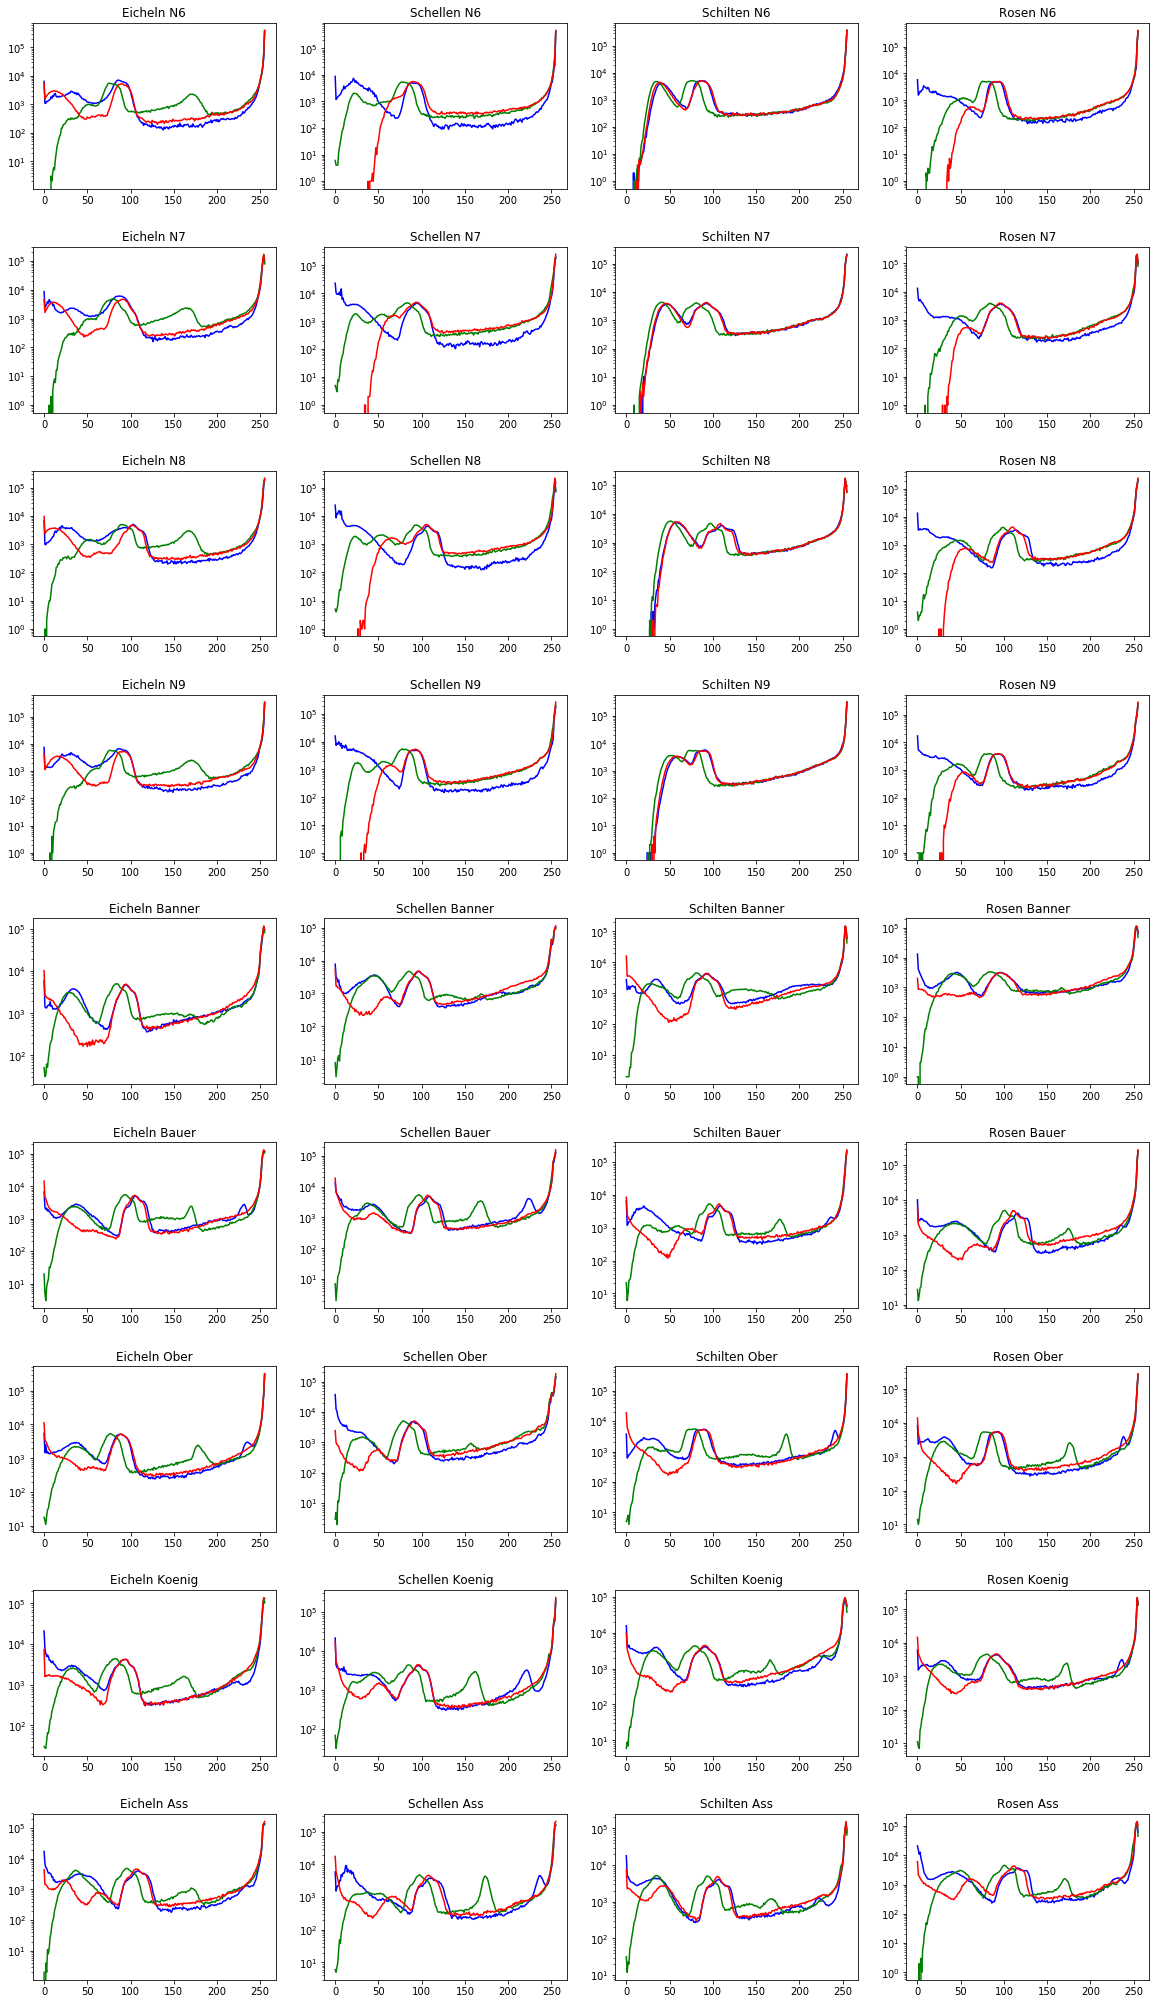

In [9]:
path = r".\images\a"
fileList = [os.path.join(dp, f) for dp, dn, filenames in os.walk(path) for f in filenames if os.path.splitext(f)[1] == '.jpg']

fig, axes = plt.subplots(nrows=9, ncols=4,figsize=[20, 36])                     # define matrix size
plt.subplots_adjust(hspace=0.35)                                                # make space between charts to read title

row=0                                                                           # row counter initialization
for cardNr in range(0,9):                                                       # row loop
    col=0                                                                       # col counter initialization
    for cardType in "a,b,c,d".split(","):                                       # loop trough cardTypes                 
        file = os.path.join(r".\images",cardType,f"{cardType}{cardNr}_{str(9-cardNr).zfill(4)}.jpg")        
        cardName=js.jassCardName(cardType.upper()+str(cardNr))                  # get cardName
        
        img = cv2.imread(file)                                                  # read image data
        #img = js.scaleImage(img,20)                                            # scaling if desired
        code=file.split("\\")[-1][0:2]                                          # code of card
        color = ('b','g','r')                                                   # the graph enumerator and color
        titel=js.jassCardName(code.upper())                                     # define titel for chart
        axes[row,col].set_title(titel)                                          # set titel in subchart      
        axes[row,col].set_yscale('log')                                         # set logarithmic scale (to many white pixels)       
        for i,col2 in enumerate(color):                                         # color enumerator
            histr = cv2.calcHist([img],[i],None,[256],[0,256])                  # calc histodata
            axes[row,col].plot(histr,color = col2)                              # plot histodata
        col=col+1                                                               # increment col
    row=row+1                                                                   # increment row
plt.show()

## Data Preparation 04

I will prepare the data appropriately for the analysis and modeling (data cleaning, manipulation, feature engineering). I'm going to analyze image data from:
* train_datascan_ii
* train_datascan_iii
* train_datascan_iv

> NOTE: I will skip the data from datascan_i as there is no need for more data and on this dataset the background would need another threshold setting to remove the wooden background.

### Data cleaning
There was only a minor data cleaning step on datascan_iii. As the image extraction from the movie may also had some images where a card was only showed partially, I did a visual check within the Windows explorer. As the frames are just in order of the time, it was a piece of cake to eliminate them. The cleaning step of my exported data was done in this manner.

### Feature Engineering

The following data are beeing collected:
* dataSet (internal use)
* cardId (will be the target feature)
* x (value of bounding box within original image)
* y (value of bounding box within original image)
* width (width of the image)
* height (height of the image)
* orgWidth (width of the original image)
* orgHeight (width of the original image)
* red channel histogram data from value r0 to r255
* green channel histogram data from value g0 to g255
* blue channel histogram data from value b0 to b255


In [10]:
import JassSummarizer as js
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from tqdm import tqdm
import shutil
import os
import cv2                                                                                  # computer vision python library see README.md dependencies
                                                                                            # computer vision python library see README.md dependencies

np.set_printoptions(suppress=True)                                      # do not use scientific notation for number in numpy
pathList= [r".\images\02_data_preparation\train_datascan_ii",r".\images\02_data_preparation\train_datascan_iii",r".\images\02_data_preparation\train_datascan_iv"]
color = ('b','g','r')                                                   # the graph enumerator and color
columnTitle=[]
                                                                                            # computer vision python library see README.md dependencies
columnTitle=columnTitle+"dataSet,cardId,x,y,width,height,orgWidth,orgHeight".split(",")     # title for the first part of columns
columnTitle=columnTitle+"".join([f"r{num}," for num in range(256)]).split(",")[0:-1]        # adding all the red color numbered labels from r0-r255
columnTitle=columnTitle+"".join([f"g{num}," for num in range(256)]).split(",")[0:-1]        # adding all the green color numbered labels from g0-g255
columnTitle=columnTitle+"".join([f"b{num}," for num in range(256)]).split(",")[0:-1]        # adding all the blue color numbered labels from b0-b255
data={}                                                                                     # dictionary to store the collected datas

if 1==2:
 for path in pathList:
    dataSet=path.split("\\")[-1].replace("train_","")
    fileList = [os.path.join(dp, f) for dp, dn, filenames in os.walk(path) for f in filenames if os.path.splitext(f)[1] == '.jpg']
    print(f"Dataset Name: {dataSet:15} includes {len(fileList):6} images on Path: {path}")    
    data[dataSet]=[]
                                                                                            # computer vision python library see README.md dependencies    
    with tqdm(total=len(fileList)) as pbar:                                                 # visualize progress
        for file in fileList:                                                               # iterate trough all images in dataset
            histr = []                                                                      # reset histogram recordset
            img=cv2.imread(file,cv2.IMREAD_COLOR)                                           # read image
            orgHeight,orgWidth = img.shape[0],img.shape[1]                                  # save original image dimensions
            frameOrg,mask,img_rect,res,crop_img,d=js.analyzeScan(img)                       # analyze image data and receive droped image
            x,y,width,height=d                                                              # store dimensions
            for i,colorChannel in enumerate(color):                                         # color enumerator
                histr.append(cv2.calcHist([crop_img],[i],None,[256],[0,256]))               # calc histodata
            r=histr[2]; g=histr[1]; b=histr[0]                                              # prepare r,g,b column data
            cardId=file.split("\\")[-1][0:2]                                                # get cardId from filename
            # concatenate all the collected data 
            data[dataSet].append(np.concatenate(([dataSet,cardId,x,y,width,height,orgWidth,orgHeight],r.flatten().astype("uint32"),g.flatten().astype("uint32"),b.flatten().astype("uint32")),axis=0).flatten())
            pbar.update(1)                                                                  # update visualization progress
        df=pd.DataFrame(np.array(data[dataSet]),columns=columnTitle)                        # add numpy array to dataframe
        df.to_csv(dataSet+".csv",header=True)                                               # save dataframe as csv including header infos


---
# 03) Exploration Data Analysis 01

As the main data is within the image itself, I have done some processing which may could support the pure Image classification process. One of the ideas was to separate the different colors per card. A human being looking at the cards can identify them real easy. May we can find some correlating data.

## Color Separation with K-mean Clustering

In the next cell I choose the Eicheln König as the best card for color separation. This card includes all colors as the others also do in one. I use 8 as the count of colors I would like to divide. The idea is to find out how much percent from an amount of color is available in each cardType. The first challenge is to find the colors which are mostly used. To solve this problem I used the K-Mean Clustering algorithm. It gives me the possibility to define how many colors (Clusters) I want to distinguish. I decided to use 8 colors.



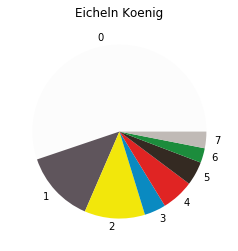

In [11]:
from sklearn.cluster import KMeans
row=0                                                                           # row counter initialization
kmeans = KMeans(n_clusters=8,random_state=0)                                    # setting clustersize to 8
                
path = r".\images\a"                                                            # defining input path
fileList = [os.path.join(dp, f) for dp, dn, filenames in os.walk(path) for f in filenames if os.path.splitext(f)[1] == '.jpg']

targetCard=fileList[7]                                                          # choose source of Eichen König
cardId=targetCard.split("\\")[-1][0:2].upper()                                  # set CardId
img = cv2.imread(targetCard)                                                    # row counter initialization
rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)                                       # convert color mode to rgb
img=rgb.reshape((img.shape[1]*img.shape[0],3))                                  # reshape for 2d input shape
s=kmeans.fit(img, y=None);                                                      # fit it

labels=list(kmeans.labels_)                                                     # get labels
centroid=kmeans.cluster_centers_                                                # get cluster centers
percent=[]                                                                      # empty percent array
for i in range(len(centroid)):                                                  # iterate trough clusters
  j=labels.count(i)                                                             # get numbered labels
  j=j/(len(labels))                                                             # calc percent value
  percent.append(j)                                                             # add percent value
plt.pie(percent,colors=np.array(centroid/255),labels=np.arange(len(centroid)))  # draw chart
plt.title(js.jassCardName(cardId))                                              # set chart title 
plt.show()
                


## Display color distribution on all cards

The following analysis checks every card for it's used colors. As _baseline_ I'm using the card Eicheln König.I'm going to show for each card a pie chart which shows the percentage per color's. Through this process I can visualize group of cards which are similar in percentage and used colors.

> The current analysis uses no threshold on the percentage value



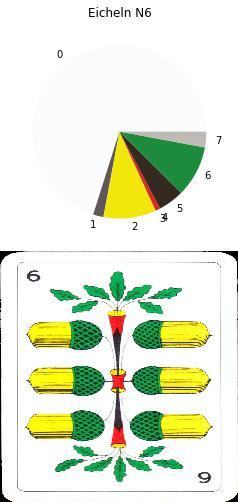
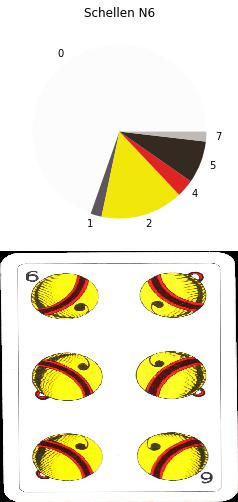
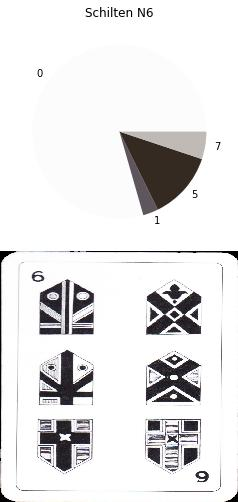
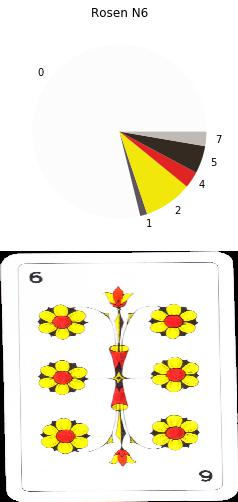
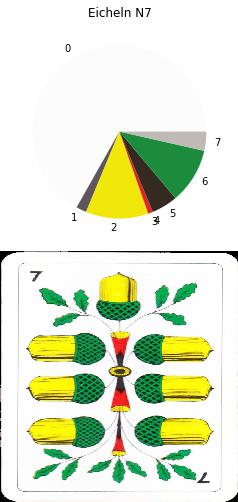
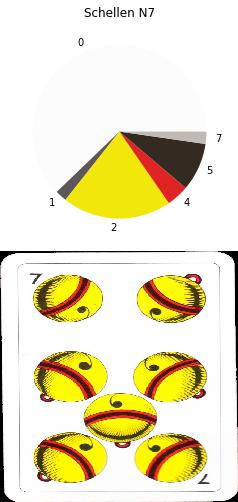
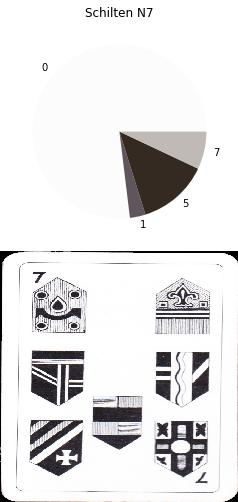
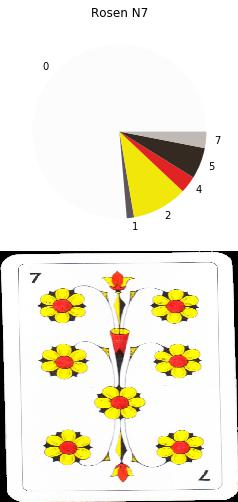
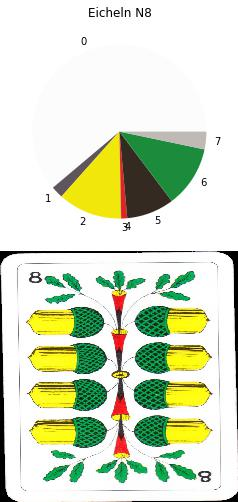
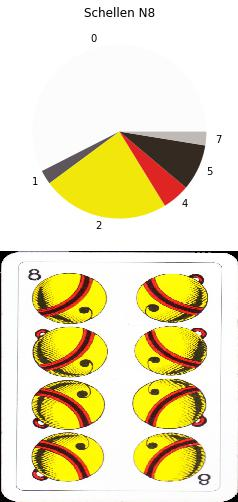
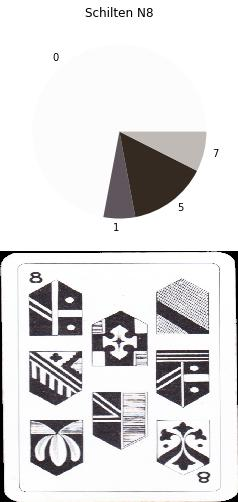
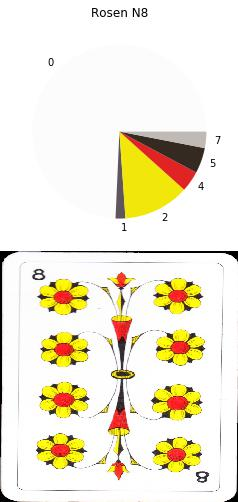
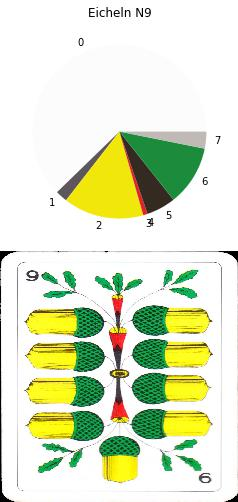
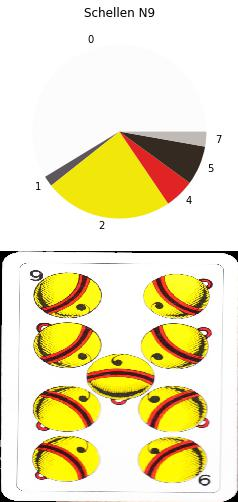
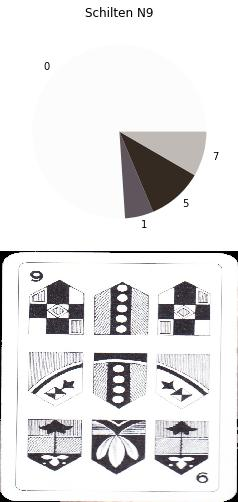
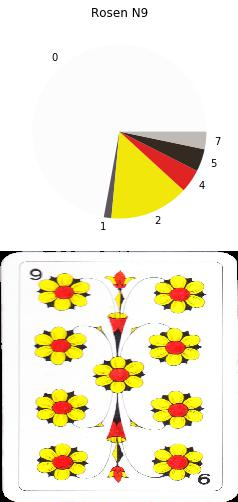
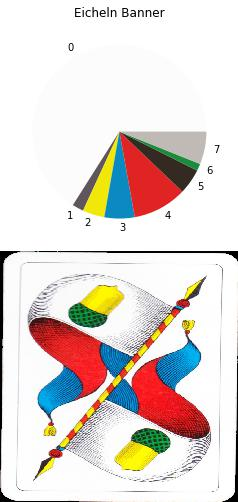
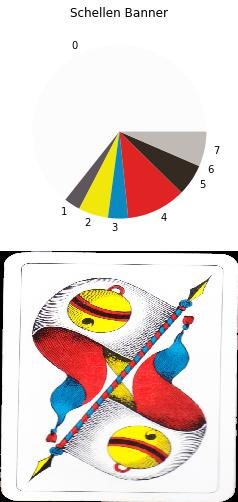
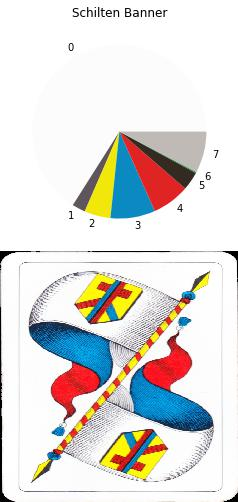
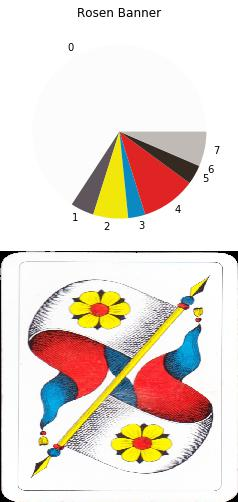
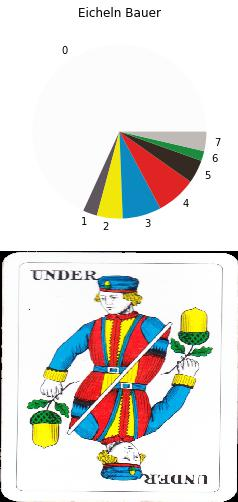
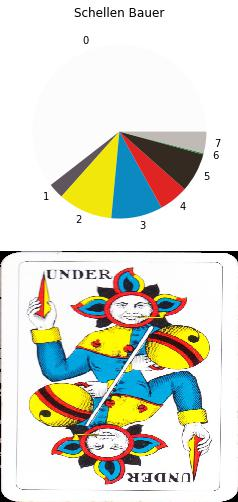
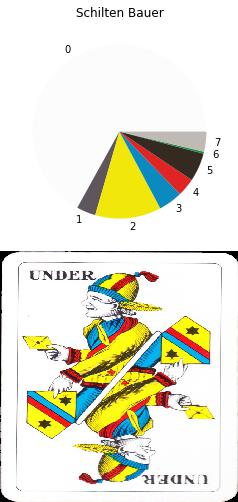
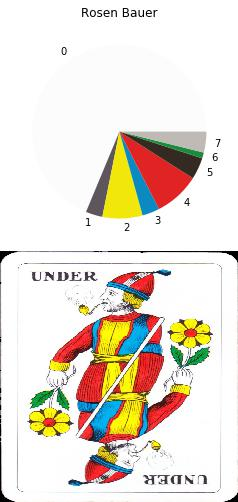
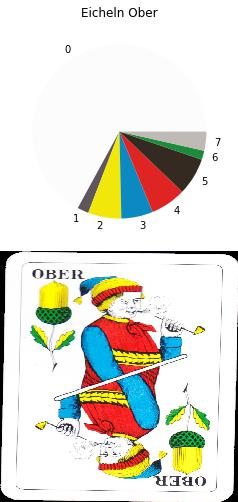
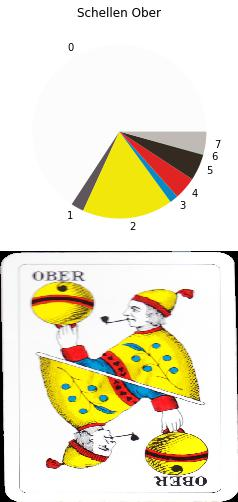
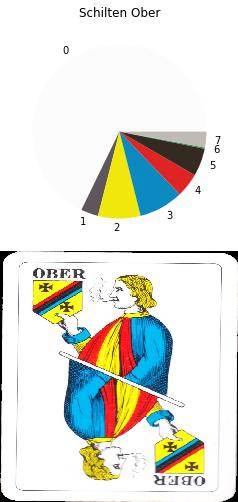
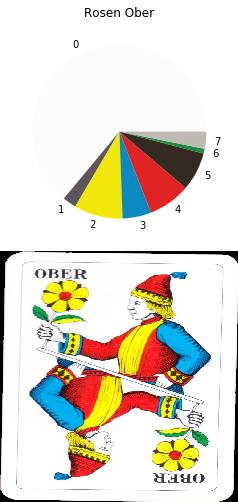
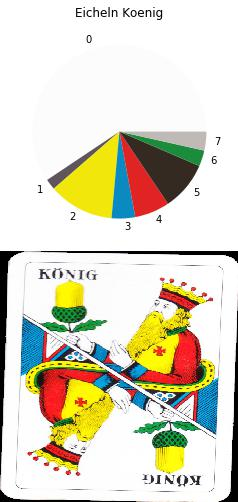
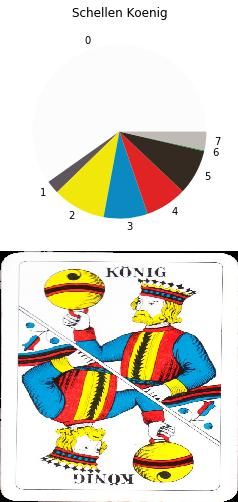
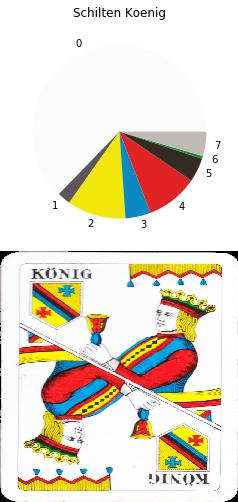
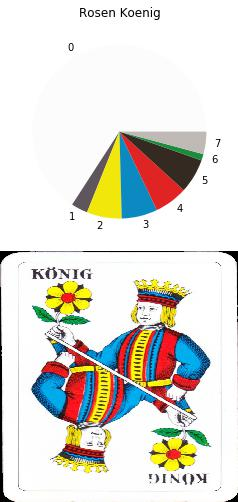
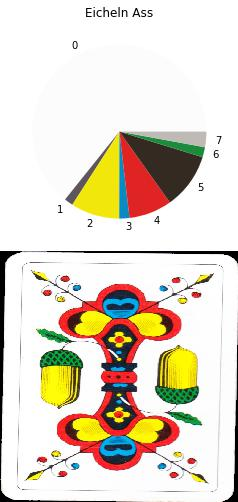
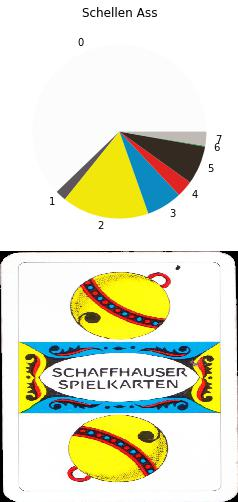
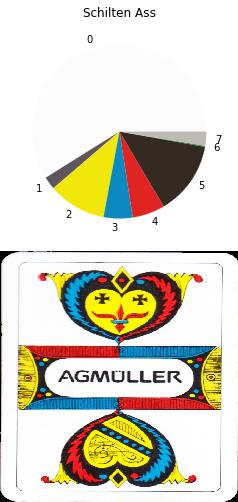
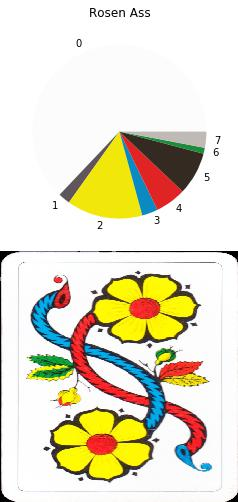

In [12]:
imageDimension=(rgb.shape[0],rgb.shape[1])
inputPath = r".\images"
cardSets=["a","b","c","d"]
fileList= []

outputPath = r".\images\temp"
if not os.path.exists(outputPath):
    os.mkdir(outputPath)

row=0                                                                           # row counter initialization
for cardNr in range(0,9):                                                       # row loop
    col=0                                                                       # col counter initialization
    for cardType in "a,b,c,d".split(","):                                       # loop trough cardTypes
        path=os.path.join(inputPath,cardType)                                   # path for image selection
        fileName=os.path.join(path,f"{cardType.upper()}{cardNr}_{str(9-cardNr).zfill(4)}.jpg")        
        img = cv2.imread(fileName)                                              # read image
        frameOrg,mask,img_rect,res,crop_img,d=js.analyzeScan(img,0.6)           # clean the gray frame around the proper card, threshold a bit higher with 0,6
        resized = cv2.resize(crop_img, imageDimension, interpolation = cv2.INTER_AREA)
        rgb = cv2.cvtColor(resized,cv2.COLOR_BGR2RGB)                           # convert to rgb
        img=rgb.reshape((imageDimension[1]*imageDimension[0],3))                # resize to chart size from Eicheln könig - feature set
        s=kmeans.predict(img)                                                   # predict colors
        percent=[]                                                              # empty 
        q=np.unique(s,return_counts=True)                                       # q stores the colors found
        total=np.sum(q[1])                                                      # count total

        index=0                                                                 # loop counter for colors found
        cent2=[]                                                                # centroid of clusters
        for i in range(len(centroid)):                                          # loop trough centroids
          if index ==len(q[0]):                                                 # are all colors done
            break                                                               # if yes break      
          if q[0][index]!=i:                                                    # if color is not available in the analyzing card
            continue                                                            # then take next
          j=100/total*q[1][index]                                               # otherwise get percentage
          cent2.append(centroid[i]/255)                                         # get color
          index=index+1                                                         # next color
          percent.append(j)                                                     # add percent value
        plt.title(js.jassCardName(f"{cardType.upper()}{cardNr}"))               # set tile in chart
        plt.pie(percent,colors=np.array(cent2),labels=q[0])                     # draw pie chart
        plt.savefig(os.path.join(outputPath,f"temp_{cardType.upper()}{cardNr}.png"), bbox_inches='tight')
        plt.close()
        col=col+1                                                                # next cardType
    row=row+1                                                                    # next card 
if 1==1:    
    col=row=0                                                                    # row counter initialization
    data=[]
    for cardNr in range(0,9):                                                    # row loop
        col=0                                                                    # col counter initialization
        for cardType in "a,b,c,d".split(","):                                    # iterate trough card types
            temp=cv2.imread(os.path.join(outputPath,f"temp_{cardType.upper()}{cardNr}.png"))
            path=os.path.join(inputPath,cardType)                                # join path
            fileName=os.path.join(path,f"{cardType.upper()}{cardNr}_{str(9-cardNr).zfill(4)}.jpg")        
            img = cv2.imread(fileName)                                           # read image
            frameOrg,mask,img_rect,res,crop_img,d=js.analyzeScan(img,0.6)        # call analyzeScan
            resized = cv2.resize(crop_img, imageDimension, interpolation = cv2.INTER_NEAREST)
            temp2= cv2.resize(resized, (temp.shape[1],temp.shape[0]), interpolation=cv2.INTER_NEAREST)
            temp2 = cv2.cvtColor(temp2,cv2.COLOR_BGR2RGB)        
            temp = cv2.cvtColor(temp,cv2.COLOR_BGR2RGB)        
            vis = np.concatenate((temp, temp2), axis=0)
            #axes[row,col].set_title(js.jassCardName(f"{cardType.upper()}{cardNr}"))
            #axes[row,col].imshow(vis)
            data.append(vis)
            col=col+1
        row=row+1
#because the mathlib figure plot did not show the images proberly,
#i used my own defined HTML output routine with inline image generation        
b=np.reshape(np.array(data),[9,4]+list(np.array(data)[0].shape))
js.display_imageTable(b)

## Explanation of the code in the next cell

The idea from the next cell is to draw for each cardType and each datascan set an RGB histogram chart.  
This chart displays in a bolder plot the average curve for red, green and blue. Also, there is a range area for the min and max value for every color channel.

> NOTE: the calculation uses in every dataset all corresponding (equal) cards  and builds the min, max and average values.  
So that are summarizations for 1159, 13904 and 6480 images.

#### Conclusion and finding

* It looks like the webcam has some differences in the red channel. It's recognizable very easy on the charts from Schilten 6 til Schilten 9 cards. Because they have just gray in it
  * If this cards are only gray, why can we find some partial red tones? If you zoom in in such scan's, you can recognize some lightly red parts on the edges.
* There are very little values between min and max on the synthetical chart (datascan iv) 
* The datascan iii has a more clearly chart representation then datascan ii. That means that the galaxy camera has the better camera compared to the webcam

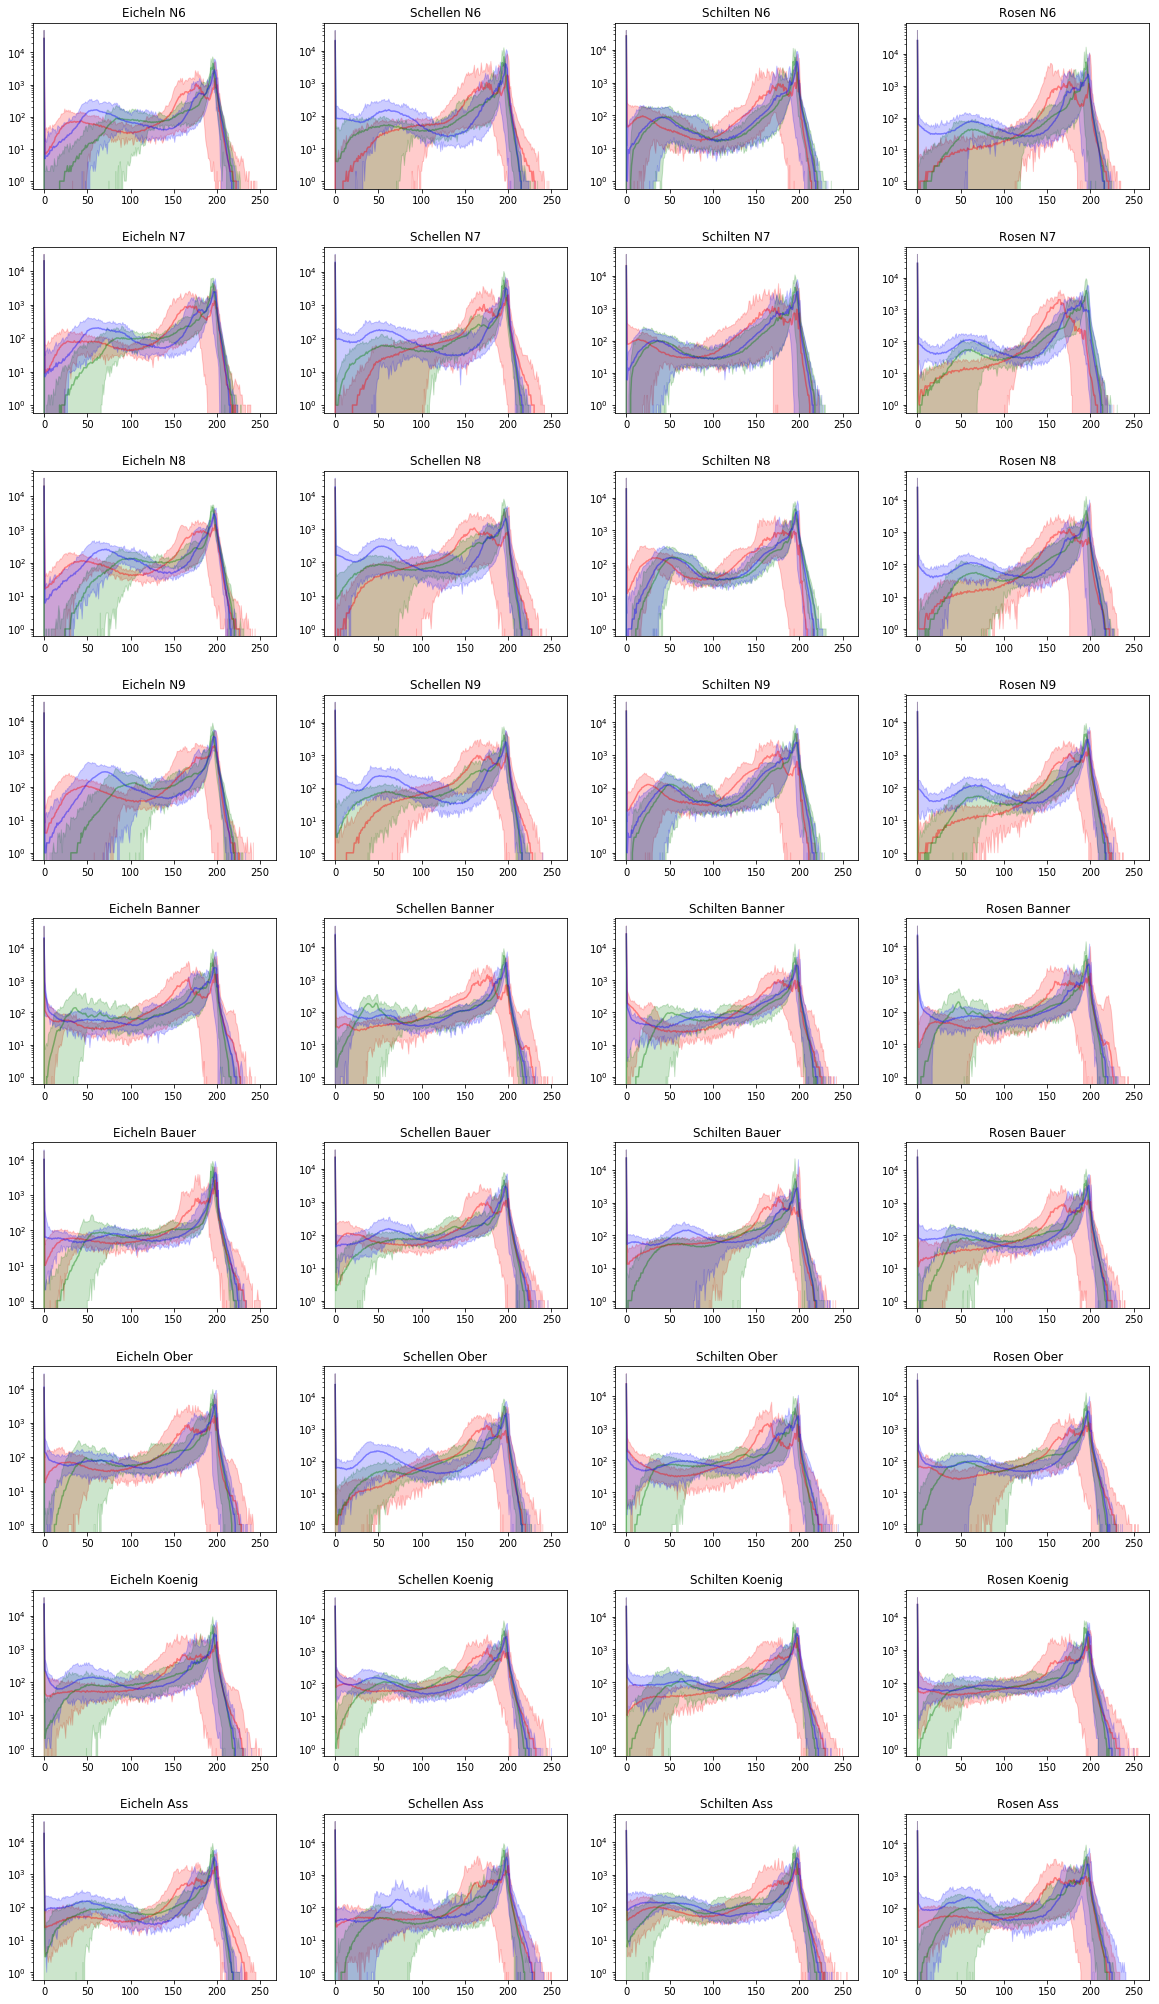

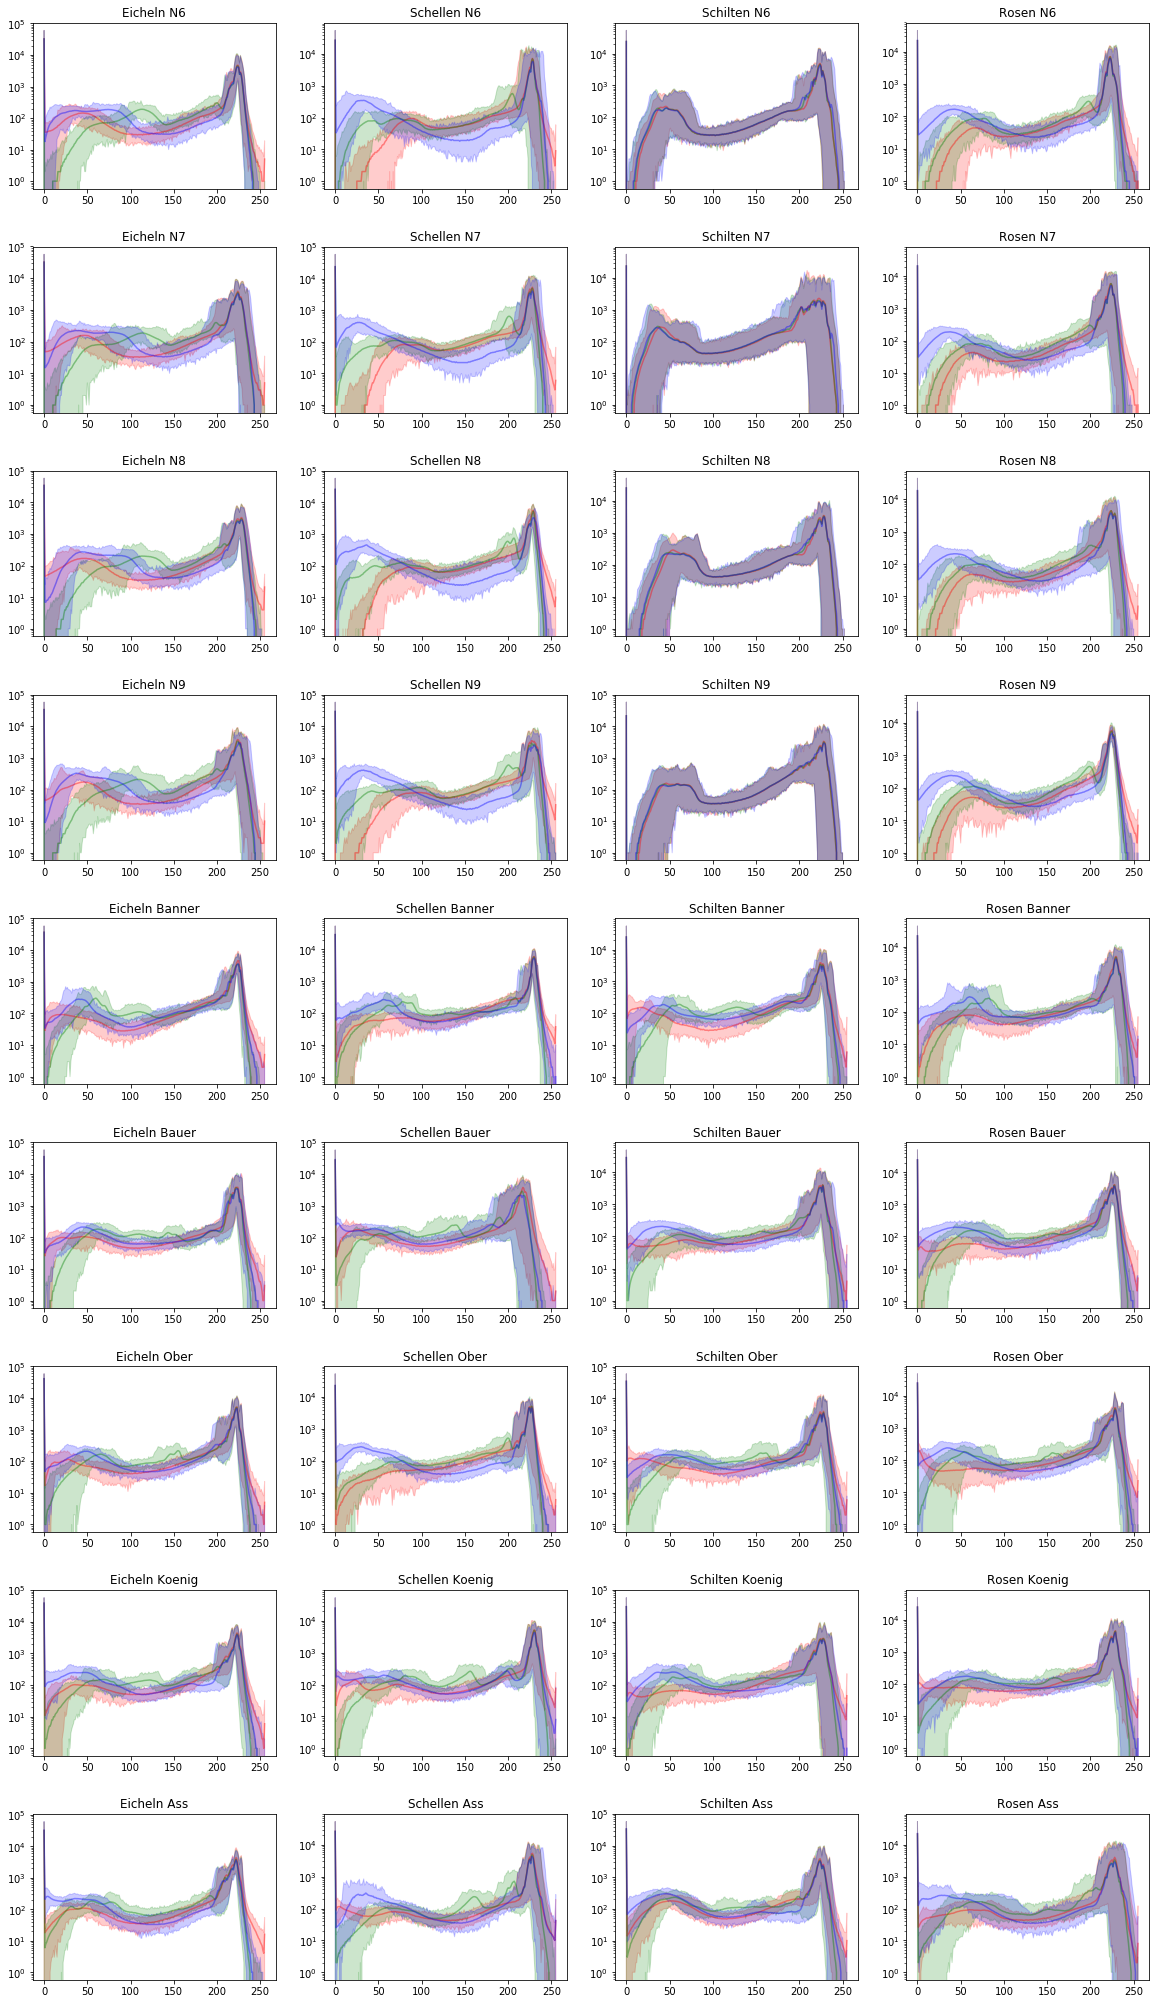

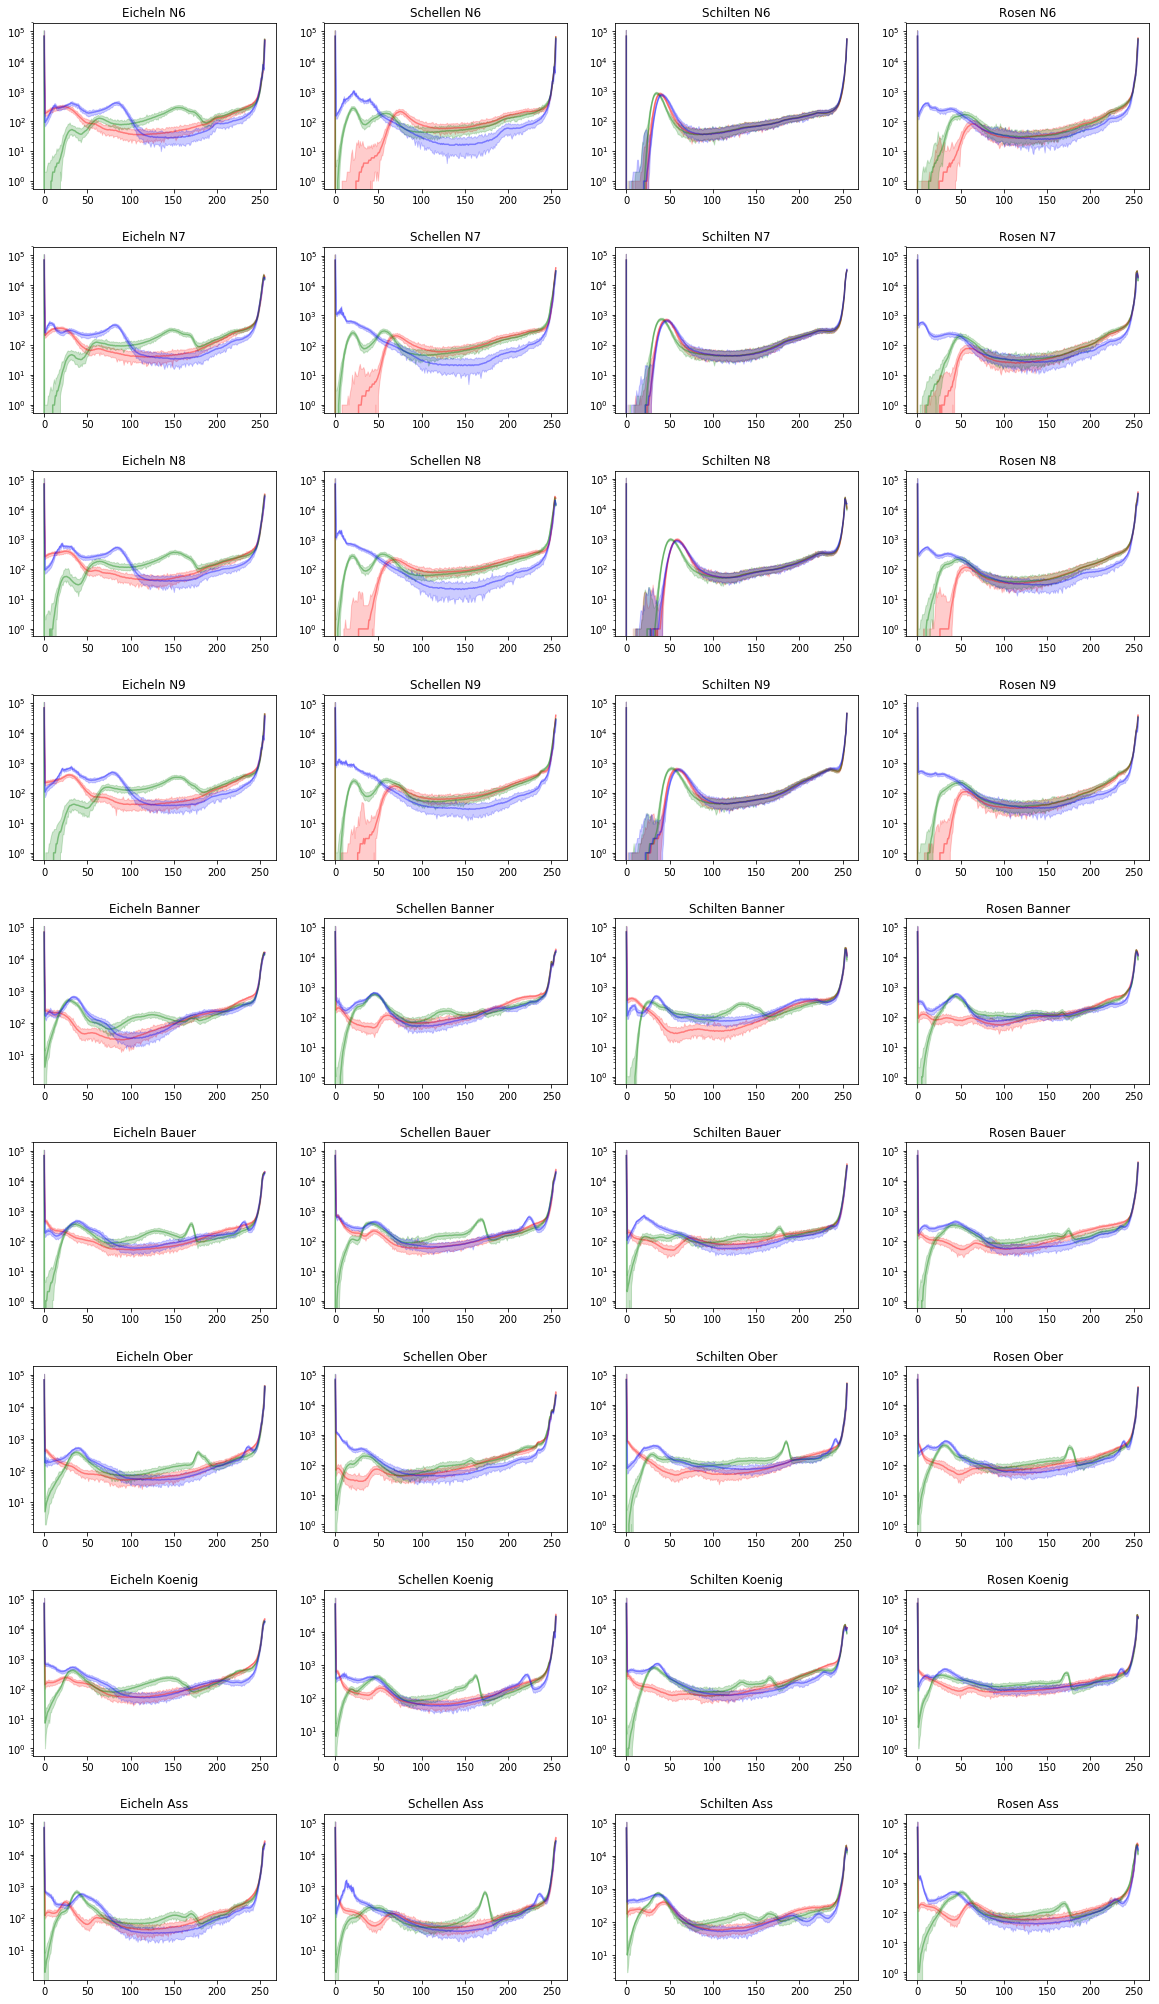

In [13]:
dataScans = ["datascan_ii.csv","datascan_iii.csv","datascan_iv.csv"]                # iterate trough available dataset
b=np.arange(0,256)                                                                  # numbered array from 0-255 for cahr x axis plot

for dataScan in dataScans:                                                          # datascan iterator
    dataScanName = dataScan.replace(".csv","")                                     # store dataset name
    df=pd.read_csv(dataScan)                                                        # load csv into dataframe
    
    display(HTML(f"<h2>RGB color histogram for: {dataScanName}</h2>"))
    display(HTML(f"<p>Total Images {df.count()[0]}</h2>"))
    display(HTML(f"<hr />"))

    fig, axes = plt.subplots(nrows=9, ncols=4,figsize=[20, 36])                     # define matrix size
    plt.subplots_adjust(hspace=0.35)                                                # make space between charts to read title

    row=0                                                                           # row counter initialization
    for cardNr in range(0,9):                                                       # row loop
        col=0                                                                       # col counter initialization
        for cardType in "a,b,c,d".split(","):                                       # loop trough cardTypes  
            cardName=js.jassCardName(cardType.upper()+str(cardNr))                  # get cardName
            cardCode=cardType.upper()+str(cardNr)                                   # cardCod is cardIdentifier
            
            # select all specific entries from tyep cardCode and only use the first 256 columns for red
            df2=pd.DataFrame(np.array(df[df["cardId"] ==cardCode])[:,9:9+256].astype("uint32"))
            a=df2.describe().T[["min","mean","max"]].astype("uint32").T
            c=a.reset_index()
            r1=(np.array(c[c["index"] =="min"])[:,1:]).astype("uint32")
            r2=(np.array(c[c["index"] =="mean"])[:,1:]).astype("uint32")
            r3=(np.array(c[c["index"] =="max"])[:,1:]).astype("uint32")
            
            # select all specific entries from tyep cardCode and only use the first 2nd 256 columns for green
            df2=pd.DataFrame(np.array(df[df["cardId"] ==cardCode])[:,9+256:9+512].astype("uint32"))
            a=df2.describe().T[["min","mean","max"]].astype("uint32").T             # calcualte min, mean and max for all identical cardTyupes in specific dataset
            c=a.reset_index()                                                       # reformating for easier selection of min,max,mean
            g1=(np.array(c[c["index"] =="min"])[:,1:]).astype("uint32")             # get min value for each G value (g0-g255)
            g2=(np.array(c[c["index"] =="mean"])[:,1:]).astype("uint32")            # get mean value for each G value (g0-g255)
            g3=(np.array(c[c["index"] =="max"])[:,1:]).astype("uint32")             # get max value for each G value (g0-g255)
            
            # select all specific entries from tyep cardCode and only use the first 3rd 256 columns for blue
            df2=pd.DataFrame(np.array(df[df["cardId"] ==cardCode])[:,9+512:].astype("uint32"))
            a=df2.describe().T[["min","mean","max"]].astype("uint32").T             # calcualte min, mean and max for all identical cardTyupes in specific dataset
            c=a.reset_index()                                                       # reformating for easier selection of min,max,mean
            b1=(np.array(c[c["index"] =="min"])[:,1:]).astype("uint32")             # get min value for each B value (b0-b255)
            b2=(np.array(c[c["index"] =="mean"])[:,1:]).astype("uint32")            # get mean value for each B value (b0-b255)
            b3=(np.array(c[c["index"] =="max"])[:,1:]).astype("uint32")             # get max value for each B value (b0-b255)

            axes[row,col].set_title(cardName)                                       # set titel in subchart      
            axes[row,col].set_yscale('log')                                         # set logarithmic scale (to many white pixels)       
            # red
            axes[row,col].plot(b,np.array(r2)[:,:].flatten(),alpha=0.4,color="r")   # draw mean curve bolder then the other. so we use alpha=0.4
            axes[row,col].fill_between(b,np.array(r1)[:,:].flatten(),np.array(r3)[:,:].flatten(),alpha=0.2,color="r")
            # green
            axes[row,col].plot(b,np.array(g2)[:,:].flatten(),alpha=0.4,color="g")   # draw mean curve bolder then the other. so we use alpha=0.4
            axes[row,col].fill_between(b,np.array(g1)[:,:].flatten(),np.array(g3)[:,:].flatten(),alpha=0.2,color="g")
            # blue
            axes[row,col].plot(b,np.array(b2)[:,:].flatten(),alpha=0.4,color="b")   # draw mean curve bolder then the other. so we use alpha=0.4
            axes[row,col].fill_between(b,np.array(b1)[:,:].flatten(),np.array(b3)[:,:].flatten(),alpha=0.2,color="b")
            col=col+1                                                               # increment col
        row=row+1                                                                   # increment row
    plt.show()        


---
# 04) Machine learning 01

During the machine learning phase, I do test multiple strategies to solve the Jasscard Classifier task. The following task will be done:

1. CNN using image dimension of 32 * 32 (CNN32)
2. CNN using image dimension of 64 * 64 (CNN64)
3. CNN using image dimension of 224 * 224 (CNN224)
4. CNN with additional data generation using image dimension of 32 * 32 (CNN32DG) and early stopping active
5. CNN with additional data generation using image dimension of 64 * 64 (CNN64DG) and early stopping active
6. CNN with additional data generation using image dimension of 224 * 224 (CNN224DG) and early stopping active
7. CNN with additional data generation using image dimension of 32 * 32 (CNN32MA) and early stopping inactive
8. CNN with additional data generation using image dimension of 64 * 64 (CNN64MA) and early stopping inactive
9. CNN with additional data generation using image dimension of 224 * 224 (CNN224MA) and early stopping inactive

10. Pretrained model using image dimension of 224 * 224 and Random Forest classifier (RMF224PT)  
11. Pretrained model using image dimension of 224 * 224 and Random Forest classifier and Hyperparameter Tuning (RMF224PT)  



## Procedure
The list of models I'm going to train is represented in an Enumeration. The Enumerator name characterizes the Model by encoding the input shape and settings for data generation (DG) and Multiple Angle (MA/early stopping).

|Resolution\Type|CNN|DG|MA|
|-|-|-|-|
|32 x 32|CNN32|CNN32DG|CNN32MA|
|64 x 64|CNN64|CNN64DG|CNN64MA|
|224 x 224|CNN224|CNN224DG|CNN224DG|

* CNN regular with early stopping
* CNNDG with data generation and early stopping
* CNNMA with data generation and without early stopping

### Machine learning loop trough all defined models (Step 1)
### Display Overview Results (Step 2)
### Display Results of top 4 Models on Accuracy and loss (Step 3)
### Verification with Confusion Matrix on last Result (Step 4)
### Verification Step from loaded Data (Step 5)
### image diffuser result check (Step 6)
### Presentation of cardId distribution for train/test dataset (Step 7)


In [14]:
import JassSummarizer as js
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from tqdm import tqdm
import shutil
import os
import cv2   

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, InputLayer, Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as keras
import tensorflow as tf
from enum import Enum
import random
import time
import re

In [15]:

cnnModels=Enum("cnnModels","CNN32,CNN32DG,CNN32MA,CNN64,CNN64DG,CNN64MA,CNN224,CNN224DG,CNN224MA",start=0)
#cnnModels=Enum("cnnModels","CNN64",start=0)                                                 # current models to investigate
trainedDataPaths=["ii","iii","iv"]                                                          # maximal dataset definition
trainedDataPaths=["v"]                                                                     # current dataset definition
import cv2                                                                                  # computer vision python library see README.md dependencies
doFilePercent=99                                                                            # percentage of images to take for training
results= pd.DataFrame([])                                                                   # initialization for results
lastMode=0                                                                                  # remembers the lastMode of resolution used

# LOOP A for each defined model
for cnnModel in cnnModels:                                                                  # iterate trought the defined models
    mode=int(re.findall(r'\d+',cnnModel.name)[0])                                           # get the nummerical value
    subMode=cnnModel.name[-2:]                                                              # get subname of current model
    size = (mode, mode)                                                                     # define size from value
    mlDimension = (mode,mode,3)                                                             # define input shape from value
    fileListMaster= []                                                                      # variable to hold multiple fileliste if multiple dataset are choosen
    pathMaster="_"                                                                          # variable to hold pultiple dataset names/paths
    
    # LOOP B accumulates test data sets
    for dataPath in trainedDataPaths:                                                       # iterate trough data path
        path = os.path.join(r".\images\02_data_preparation", "train_datascan_"+dataPath)    # generate path
        pathMaster += dataPath                                                              # store pultiple dataset names/paths
        fileList = [os.path.join(dp, f) for dp, dn, filenames in os.walk(path) for f in filenames if os.path.splitext(f)[1] == ".jpg"]

        if (doFilePercent !=100):                                                           # if not 100%
            a=fileList                                                                      # temporary variable
            random.shuffle(a)                                                               # shuffle them
            percent=int(len(fileList)/100*doFilePercent)                                    # take percentage of files
            fileList=a[0:percent]                                                           # store them back
            
        fileListMaster=fileListMaster+fileList                                              # accumulate
    path=pathMaster                                                                         # restore to standard variable
    fileList=fileListMaster                                                                 # restore to standard variable
    print(f"Analyzing Model {cnnModel.name}, by {mode}x{mode} with {len(fileList)} images | Time {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    time.sleep(0.3)
    
    if not ('X' in locals() and lastMode==mode and (len(X)+len(y) == 2*len(fileList))):
        X=[] ;y=[]                                                                              # initialize
        lastMode=mode                                                                           # remember mode which is currently loading/loaded

        # Loop C iterates through  all images
        with tqdm(total=len(fileList)) as pbar:                                                 # progressbar initialization
            for fName in fileList:                                                              # iterate trough files
                nameOnly=fName.split("\\")[-1]                                                  # take name
                cardId=nameOnly[0:2]                                                            # take caredId 
                myImage=cv2.imread(fName,cv2.IMREAD_COLOR)                                      # read image data
                data=js.analyzeScan(myImage,0.4)                                                # analyzeScan of image
                frameOrg,mask,img_rect,res,crop_img, d = data                                   # distribute results
                resized = cv2.resize(crop_img, size, interpolation = cv2.INTER_AREA)            # resize depending on current model
                r2=cv2.cvtColor(resized,cv2.COLOR_BGR2RGB)                                      # adjust color channels
                r3=js.backgroundDiffuser3(r2)                                                   # prevent black background
                X.append(r3)                                                                    # append trainings data
                y.append([js.JassCN2[cardId].value])                                            # append target
                pbar.update(1)                                                                  # update progress bar

    # split data into train , test and filetarget names,
    x_train_raw, x_test_raw, y_train_raw, y_test_raw = train_test_split(np.array(X),np.array(y,dtype="O"), test_size=0.2, random_state=42)    

    if subMode=="DG" or subMode=="MA":                                                       # submode MA = multiple angel
        train_generator = ImageDataGenerator(rescale=1/255,horizontal_flip=False,rotation_range=45, brightness_range=(0.5, 1.5),validation_split=0.2)
    else:                                                                                    # submode regular
        train_generator = ImageDataGenerator(rescale=1/255,horizontal_flip=False,validation_split=0.2)
    test_generator = ImageDataGenerator(rescale=1/255)                                       # normalize color values

    y_train = tf.keras.utils.to_categorical(y_train_raw, num_classes=36)                     # provide targets
    y_test = tf.keras.utils.to_categorical(y_test_raw, num_classes=36)                       # provide targets

    trainset = train_generator.flow(x_train_raw,y_train,shuffle=True,subset='training',batch_size=64)
    validset = train_generator.flow(x_train_raw,y_train,shuffle=False,subset='validation',batch_size=64)
    testset  =  test_generator.flow(x_test_raw,y_test,shuffle=False,batch_size=32)

    #y_train = tf.keras.utils.to_categorical(y_train_raw, num_classes=36)
    #y_test = tf.keras.utils.to_categorical(y_test_raw, num_classes=36)

    print('x_train.shape', x_train_raw.shape)                                                 # print current shapes
    print('x_test.shape', x_test_raw.shape)                                                   # print current shapes

    # define CNN layer 
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=64, kernel_size=5, strides=2,activation='relu', input_shape=mlDimension))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,activation='relu'))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(36, activation="softmax"))
    model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=["acc"])
    #model.summary()

    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
    if subMode=="MA":                                                                       # do use all epochs on submode MA
        hist = model.fit_generator(generator=trainset,validation_data=validset, verbose=0, epochs=150)
    else:                                                                                   # use early stopping if not submode MA
        hist = model.fit_generator(generator=trainset,validation_data=validset, verbose=0, epochs=150, callbacks=[early_stopping])

    x_train=x_train_raw/255                                                                 # recalculate
    x_test=x_test_raw/255                                                                   # recalculate
    loss, acc = model.evaluate(x_train, y_train, batch_size=250, verbose=0)                 # do it and store results for later use
    results=results.append( { "model": cnnModel.name ,"set":"train","loss": "{:.3f}".format(loss) , "acc": "{:.3f}".format(acc) 
            ,"x_loss": hist.history["loss"], "x_acc": hist.history["acc"],"val_loss": hist.history["val_loss"], "val_acc": hist.history["val_acc"] },ignore_index=True)
    loss, acc = model.evaluate(x_test, y_test, batch_size=250, verbose=0)
    results=results.append( { "model": cnnModel.name ,"set":"test","loss": "{:.3f}".format(loss) , "acc": "{:.3f}".format(acc) 
            ,"x_loss": hist.history["loss"], "x_acc": hist.history["acc"],"val_loss": hist.history["val_loss"], "val_acc": hist.history["val_acc"] },ignore_index=True)

    if 1==1:                                                                                # if desired save the train results/weights
        if not os.path.exists(r".\model_save"):
            os.mkdir(r".\model_save")           
        modelName=f"{cnnModel.name}_{path.split('_')[-1]}_{doFilePercent}"                  # identify running model to have facts in store name
        modelFile=os.path.join(r".\model_save",modelName)                                   # join parts
        model_json = model.to_json()                                                        # convert to json
        with open(modelFile+".json", "w") as json_file:                                     # get file handle
            json_file.write(model_json)                                                     # write it 
        model.save_weights(modelFile+".h5")                                                 # store weights
print(f"| Time {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
  

Analyzing Model CNN32, by 32x32 with 68670 images | Time 2021-03-19 10:43:38


100%|███████████████████████████████████████████████████████████████████████████| 68670/68670 [07:33<00:00, 151.28it/s]


x_train.shape (54936, 32, 32, 3)
x_test.shape (13734, 32, 32, 3)
Analyzing Model CNN32DG, by 32x32 with 68670 images | Time 2021-03-19 10:52:47
x_train.shape (54936, 32, 32, 3)
x_test.shape (13734, 32, 32, 3)
Analyzing Model CNN32MA, by 32x32 with 68670 images | Time 2021-03-19 11:07:39
x_train.shape (54936, 32, 32, 3)
x_test.shape (13734, 32, 32, 3)
Analyzing Model CNN64, by 64x64 with 68670 images | Time 2021-03-19 12:00:34


100%|████████████████████████████████████████████████████████████████████████████| 68670/68670 [24:33<00:00, 46.61it/s]


x_train.shape (54936, 64, 64, 3)
x_test.shape (13734, 64, 64, 3)
Analyzing Model CNN64DG, by 64x64 with 68670 images | Time 2021-03-19 12:28:01
x_train.shape (54936, 64, 64, 3)
x_test.shape (13734, 64, 64, 3)
Analyzing Model CNN64MA, by 64x64 with 68670 images | Time 2021-03-19 12:52:47
x_train.shape (54936, 64, 64, 3)
x_test.shape (13734, 64, 64, 3)
Analyzing Model CNN224, by 224x224 with 68670 images | Time 2021-03-19 14:51:18


100%|██████████████████████████████████████████████████████████████████████████| 68670/68670 [4:47:11<00:00,  3.99it/s]


x_train.shape (54936, 224, 224, 3)
x_test.shape (13734, 224, 224, 3)
Analyzing Model CNN224DG, by 224x224 with 68670 images | Time 2021-03-19 19:57:54
x_train.shape (54936, 224, 224, 3)
x_test.shape (13734, 224, 224, 3)
Analyzing Model CNN224MA, by 224x224 with 68670 images | Time 2021-03-20 00:18:21
x_train.shape (54936, 224, 224, 3)
x_test.shape (13734, 224, 224, 3)


MemoryError: 

In [17]:
# Step 2
display(HTML("<h2>Results</h>"))
display(HTML("<h3>Accuracy results for trained models</h3>"))
results[results["set"] == "test"].sort_values(["acc"],ascending=False)[["model","acc","loss","set"]]

model    acc   loss   set
7      CNN64  0.998  0.010  test
11   CNN64MA  0.998  0.008  test
13    CNN224  0.998  0.011  test
9    CNN64DG  0.997  0.014  test
15  CNN224DG  0.997  0.014  test
1      CNN32  0.992  0.028  test
5    CNN32MA  0.985  0.050  test
3    CNN32DG  0.984  0.052  test

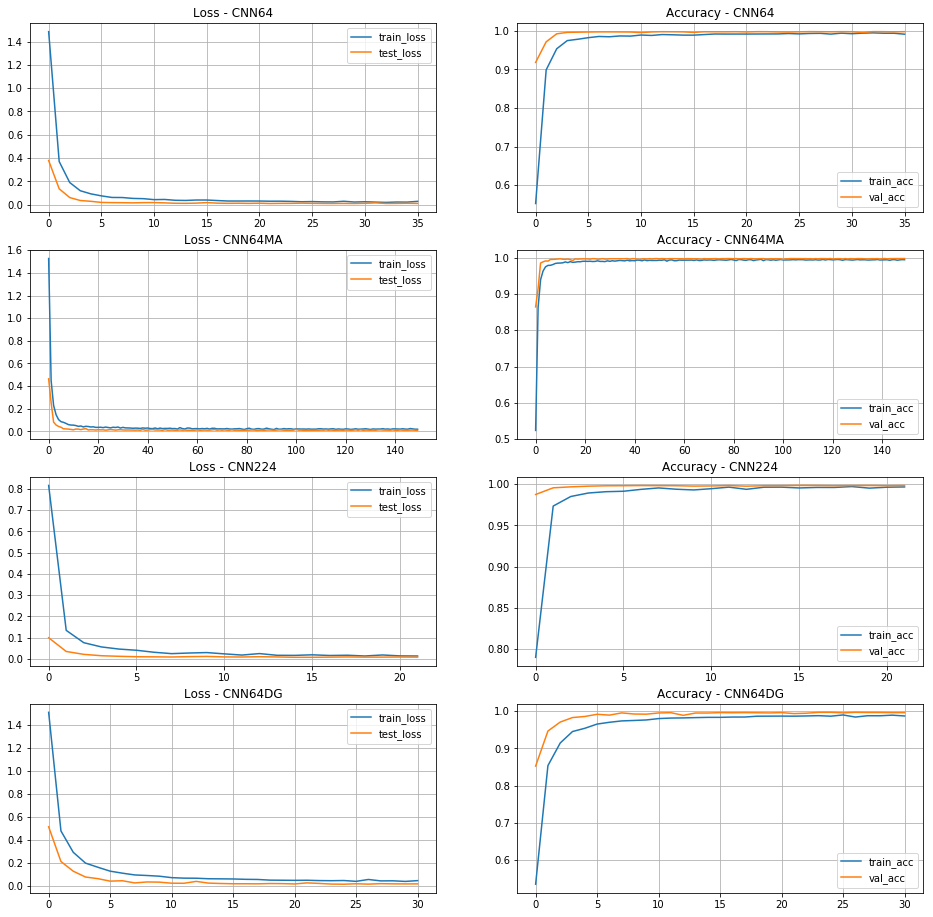

In [18]:
# Step 3
topCount= len(cnnModels) if len(cnnModels)<4 else 4
display(HTML(f"<h3>Top {topCount} models</h3>"))
resTopChart=results[results["set"] == "test"].sort_values(["acc"],ascending=False).head(4)
fig, axes = plt.subplots(nrows=topCount, ncols=2, figsize=[16, 16])
for j in range(0,topCount):
    resData=resTopChart[j:j+1]
    axes[j][0].plot(np.array(resData['x_loss'].values[0]), label="train_loss")
    axes[j][0].plot(np.array(resData['val_loss'].values[0]), label='test_loss')
    axes[j][0].set_title(f"Loss - {resData['model'].values[0]}")
    axes[j][0].legend()
    axes[j][0].grid()
    axes[j][1].plot(np.array(resData['x_acc'].values[0]), label='train_acc')
    axes[j][1].plot(np.array(resData['val_acc'].values[0]), label='val_acc')
    axes[j][1].set_title(f"Accuracy - {resData['model'].values[0]}")
    axes[j][1].legend()
    axes[j][1].grid()

### Verification
I will now plot a confusion matrix to may detect a accumulation of false prediction between specific cards

In [19]:
# Step 4
from sklearn.metrics import confusion_matrix
pd.options.display.max_columns = None                                                       # disable hiding columns
display(HTML("<h3>Confusion Matrix</h3>"))                                                  # print title
test=[]                                                                                     # initialize array
for item in y_test:                                                                         # iterate trough test scores
    test=test+[item.argmax()]                                                               # store true value
y_predict=model.predict(x_test)                                                             # get prediction values
matrix = confusion_matrix(y_true=test, y_pred=np.argmax(y_predict, axis=1))                 # build matrix
cmDf=pd.DataFrame(matrix.astype("O"))                                                       # as string type
cmDf=cmDf.replace(0,".")                                                                    # for better visualizing replace 0 with .
#cmDf=pd.DataFrame(matrix)                                                                  # store array in DataFrame
newColumn=[]                                                                                # generate new column
for card in js.JassCN2._member_names_:                                                      # iterate trough CardId keys
    newColumn=newColumn+[card]                                                              # add key

cmDf.columns=newColumn                                                                      # replaye column names
cmDf                                                                                        # print dataframe
cmDf.style.set_table_styles(                                                                # set stlye to support vertical alignment
    [dict(selector="th",props=[('max-width', '10px')]),
        dict(selector="th.col_heading",
                 props=[("writing-mode", "vertical-rl"), 
                        ('transform', 'rotateZ(-90deg)'),
                        ])])


### Verification Step from loaded Data

Too verify visually was my code is doing, you can enable visual Check

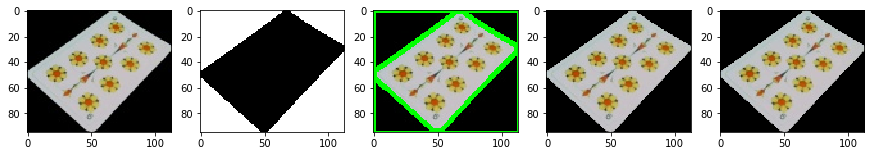

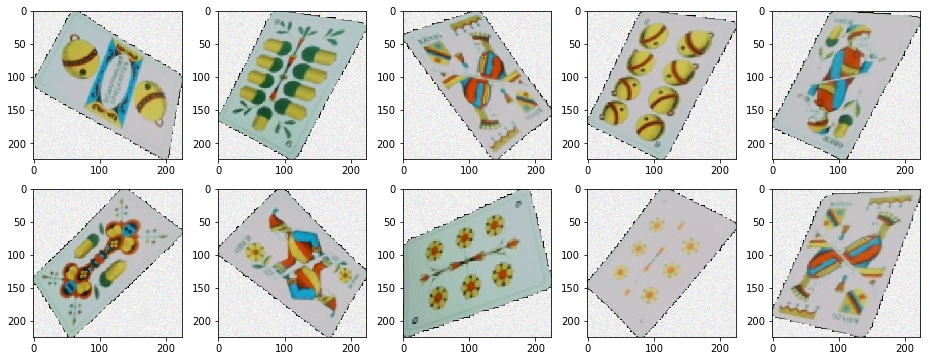

In [20]:
# Step 5
visualCheck= True
if visualCheck:
    display(HTML("<h3>analyzeImage result check<h3>"))
    fig=plt.figure(figsize=(15,15))
    i=col=1
    for item in data[0:-1]:
        temp=cv2.cvtColor(item,cv2.COLOR_BGR2RGB)
        fig.add_subplot(1, 5, i)
        plt.imshow(temp)
        i=i+1
    plt.show()
    
# Step 6
    display(HTML("<h3>image diffuser result check</h3>"))
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=[16, 6])
    for i in range(10):
        row=int(i/len(axes));    col=i%len(axes)
        axes[col,row].set_title("")
        axes[col,row].imshow(X[i])

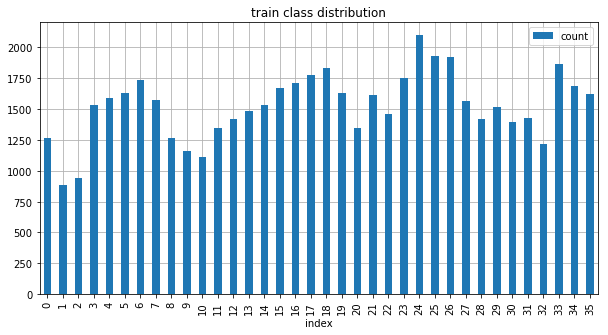

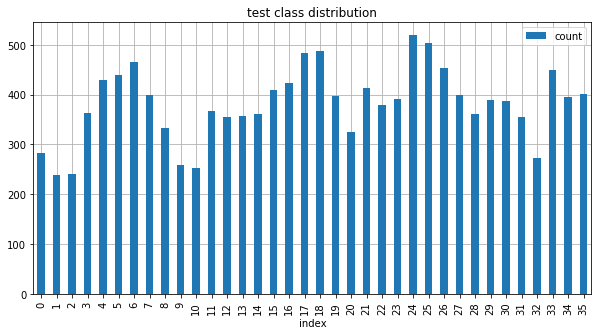

In [21]:
# Step 7
display(HTML("<h3>Distribution of cardId for train and test Data</h3>"))
pd.DataFrame(pd.Series(np.argmax(y_train,axis=1)).value_counts(),columns=["count"]).reset_index().sort_values("index").set_index("index").plot(kind="bar",
        grid=True,figsize=(10,5),title="train class distribution",zorder=10)
pd.DataFrame(pd.Series(np.argmax(y_test,axis=1)).value_counts(),columns=["count"]).reset_index().sort_values("index").set_index("index").plot(kind="bar",
        grid=True,figsize=(10,5),title="test class distribution",zorder=10)

In [22]:
import winsound                                              # signalize progress
duration = 3000                                              # milliseconds
freq = 1440                                                  # Hz
winsound.Beep(freq, duration)  

---
# 04 Machine learning 02
## Pretrained model "mobilenet" with Random-Forest Classifier

### Procedure in general
1. Define model name and input data set path for images
2. Define Mobilenet as pretrained model to load from
3. Load data defined by step 1, and preprocess it with pretrained model; results in => new features per data set
4. Apply Random Forest classifier on featured datas from step 3 with 80 estimators
5. Doing a short loop to check quickly the change of the accuracy (before I will use hyperparameter tuning).  
  5.1 Display wrong predictions  
  5.2 Display confusion matrix  
  5.3 Display class distribution  


In [8]:
# Step 1
import JassSummarizer as js
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from tqdm import tqdm
import shutil
import os
import cv2   

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, InputLayer, Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as keras
import tensorflow as tf
from enum import Enum
import random
import time
import re
import tensorflow_hub as hub

cnnModels=Enum("cnnModels","RMF224PT",start=0)                                                     # name model
trainedDataPaths=["ii","iii","iv"]                                                                 # available dataPaths
trainedDataPaths=["ii"]                                                                            # used Datapaths
img_graph = tf.Graph()                                                                             # Create graph
doFilePercent=100
results= pd.DataFrame([])

# Step 2
img_graph = tf.Graph()                                                                             # Create graph
with img_graph.as_default():
    module_url = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2'         # library url
    feature_extractor = hub.Module(module_url)                                                     # Download module
    input_imgs = tf.placeholder(dtype=tf.float32, shape=[None, 224, 224, 3])                       # Create input placeholder
    imgs_features = feature_extractor(input_imgs)                                                  # A node with the features
    init_op = tf.group([tf.global_variables_initializer(), tf.tables_initializer()])               # Collect initializers
img_graph.finalize()                                                                               # Good practice: make the graph "read-only"

# Step 3
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"                                                              # disable GPU

# LOOP A
for cnnModel in cnnModels:                                                                             # leave loop even if just One model is defined
    mode=int(re.findall(r'\d+',cnnModel.name)[0])                                                      # get image dimension
    subMode=cnnModel.name[-2:]                                                                         # get subMode name
    size = (mode, mode)                                                                                # define size
    mlDimension = (mode,mode,3)                                                                        # define input shape
    fileListMaster= []                                                                                 # define fileListMaster
    pathMaster="_"                                                                                     # define pathMaster
    
    # LOOP B    
    for dataPath in trainedDataPaths:                                                                  # loop if more then one dataPath is used
        path = os.path.join(r".\images\02_data_preparation", "train_datascan_"+dataPath)               # generate path
        pathMaster += dataPath                                                                         # store path for later identifications
        fileList = [os.path.join(dp, f) for dp, dn, filenames in os.walk(path) for f in filenames if os.path.splitext(f)[1] == ".jpg"]

        if (doFilePercent !=100):                                                                      # shuffle and slice percentage
            a=fileList                                                                                 # temporary variable
            random.shuffle(a)                                                                          # shuffle entries
            percent=int(len(fileList)/100*doFilePercent)                                               # slice
            fileList=a[0:percent]                                                                      # reassign
            
        fileListMaster=fileListMaster+fileList                                                         # used on multiple dataPath
    path=pathMaster                                                                                    # reassign path selections
    fileList=fileListMaster                                                                            # reassign collected samples
    display(HTML(f"<h3>Analyzing Model {cnnModel.name}, by {mode}x{mode} with {len(fileList)} images</h3>"))   # inform about selected trainings data
    time.sleep(0.3)                                                                                    # short sleeper because of tqm output 

    X=[] ;y=[]                                                                                         # initialize
    modelData = {}                                                                                     # initialize

    with tqdm(total=len(fileList)) as pbar:                                                            # progess bar
        for fName in fileList:                                                                         # file/image iterator
            nameOnly=fName.split("\\")[-1]                                                             # extract filename
            cardId=nameOnly[0:2]                                                                       # extract cardId
            myImage=cv2.imread(fName,cv2.IMREAD_COLOR)                                                 # read imageDate
            data=js.analyzeScan(myImage,0.4)                                                           # preprocess image data
            frameOrg,mask,img_rect,res,crop_img, d = data                                              # separate results
            resized = cv2.resize(crop_img, size, interpolation = cv2.INTER_AREA)                       # resize to input shape
            r2=cv2.cvtColor(resized,cv2.COLOR_BGR2RGB)                                                 # BGR 2 RGB color channel switch
            r3=js.backgroundDiffuser3(r2)                                                              # background optimization
            X.append(r3/255)                                                                           # normalize to fractions
            y.append([cardId.upper()])                                                                 # save cardId for later y_train or y_test
            pbar.update(1)                                                                             # update progress bar

    # split data into train and test
    X_train_raw, X_test_raw, y_train_raw, y_test_raw ,y_train_file, y_test_file = train_test_split(
        np.array(X),np.array(y,dtype="O"), np.array(fileList), test_size=0.2, random_state=42, stratify=y)
    
    for dataSet in ["train","test"]:
        img_batch=eval("X_"+dataSet+"_raw")
        initialization_op = tf.global_variables_initializer()                                          # Init
        sess = tf.Session(graph=img_graph)                                                             # Create a session
        sess.run(init_op)                                                                              # Initialize it
        features = sess.run(imgs_features, feed_dict={input_imgs: img_batch})                          # Extract features
        key=f"X_{dataSet.replace('_raw','')}_features"                                                 # dictionary keyName set
        modelData[key]=features                                                                        # put array into dict
        key=f"y_{dataSet.replace('_raw','')}_targets"                                                  # set keyName for y values
        modelData[key]=eval("y_"+dataSet+"_raw")                                                       # put array into dict
        print(f"dataPath: {path}, dataset: {dataSet:6} with {features.shape[0]:6} entries, features: {features.shape[1]} ")                                                   
    np.savez("pretrainedFeatureData", dict=modelData)                                                  # save feature and targets as pickle file                                                      

    
    
    if 1==2:
        modelName=f"{cnnModel.name}_{path.split('_')[-1]}_{doFilePercent}"
        modelFile=os.path.join(r".\model_save",modelName)
        model_json = model.to_json()
        with open(modelFile+".json", "w") as json_file:
            json_file.write(model_json)
        model.save_weights(modelFile+".h5")
  

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


100%|██████████████████████████████████████████████████████████████████████████████| 1154/1154 [04:41<00:00,  4.10it/s]


dataPath: _ii, dataset: train  with    923 entries, features: 1280 
dataPath: _ii, dataset: test   with    231 entries, features: 1280 


In [9]:
# Step 4
from sklearn.ensemble import RandomForestClassifier

X_train=modelData["X_train_features"]
X_test=modelData["X_test_features"]
y_train=modelData["y_train_targets"].reshape(-1)
y_test=modelData["y_test_targets"].reshape(-1)

model = RandomForestClassifier(n_estimators=80)
model.fit(X_train,y_train)
if 1==1:
    for j, modelName in enumerate(["train","test"]):    
        scoreRF=model.score(eval(f"X_{modelName}"), eval(f"y_{modelName}"))
        print("Accuracy {0:7} set is {1:7.3f}%".format(modelName,scoreRF*100)) 
    display(HTML("<h3>Random Forest score {} with 80 estimators(Trees)</h3>".format(scoreRF)))

Accuracy train   set is 100.000%
Accuracy test    set is  93.939%


In [10]:
# Step 5
from sklearn.ensemble import RandomForestClassifier

for j in np.arange(10,200,10):
    model = RandomForestClassifier(n_estimators=j, max_depth=None, random_state=0)
    model.fit(X_train,y_train)
    score = model.score(X_test,y_test)
    print("Random Forest score {0:7.2f} with {1:} estimators(Trees)".format(score*100,j))

Random Forest score   90.04 with 10 estimators(Trees)
Random Forest score   90.91 with 20 estimators(Trees)
Random Forest score   91.77 with 30 estimators(Trees)
Random Forest score   92.64 with 40 estimators(Trees)
Random Forest score   93.51 with 50 estimators(Trees)
Random Forest score   94.37 with 60 estimators(Trees)
Random Forest score   95.67 with 70 estimators(Trees)
Random Forest score   93.94 with 80 estimators(Trees)
Random Forest score   93.94 with 90 estimators(Trees)
Random Forest score   93.94 with 100 estimators(Trees)
Random Forest score   93.51 with 110 estimators(Trees)
Random Forest score   94.81 with 120 estimators(Trees)
Random Forest score   94.81 with 130 estimators(Trees)
Random Forest score   95.24 with 140 estimators(Trees)
Random Forest score   94.37 with 150 estimators(Trees)
Random Forest score   94.81 with 160 estimators(Trees)
Random Forest score   94.81 with 170 estimators(Trees)
Random Forest score   94.81 with 180 estimators(Trees)
Random Forest score

In [11]:
y_predicted=model.predict(X_test)

for j, predict in enumerate(y_predicted):
    if predict != y_test[j]:
        print(predict,y_test[j])

B3 B2
B3 B2
D1 D2
D8 C5
D8 B1
D3 D2
C0 C1
A0 A1
A3 A2
B3 B2
D5 D7
B3 B2


In [12]:
# Step 5.2 
import sklearn.metrics

pd.options.display.max_columns = None                                                                  # disable column hiding
display(HTML("<h3>Confusion Matrix</h3>"))                                                             # print title

y_true = y_test                                                                                        # get data
y_pred = y_predicted                                                                                   # get data
newColumn=[]                                                                                           # initialize

r = sklearn.metrics.confusion_matrix(y_true, y_pred)                                                   # get confusion matrix
cmDf=pd.DataFrame(r.astype("O"))                                                                       # as string type
cmDf=cmDf.replace(0,".")                                                                               # for better visualizing replace 0 with .
for card in js.JassCN2._member_names_:                                                                 # make nice column names
    newColumn=newColumn+[card]                                                                         # next Card Id to column
cmDf.columns=newColumn                                                                                 # apply new column names
cmDf                                                                                                   # display dataframe and set column header
cmDf.style.set_table_styles(
    [dict(selector="th",props=[('max-width', '10px')]),
        dict(selector="th.col_heading",
                 props=[("writing-mode", "vertical-rl"), 
                        ('transform', 'rotateZ(-90deg)'),
                        ])])

In [13]:
import winsound                                              # signalize progress
duration = 1500                                              # milliseconds
freq = 1440                                                  # Hz
winsound.Beep(freq, duration)  

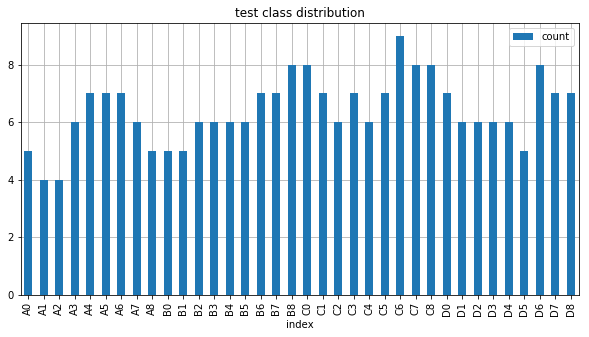

In [14]:
# Step 5.3 
pd.DataFrame(pd.Series(y_test).value_counts(),columns=["count"]).reset_index().sort_values("index").set_index("index").plot(kind="bar",
        grid=True,figsize=(10,5),title="test class distribution",zorder=10)


---
# 04 Machine learning 03
## Pretrained model "mobilenet" with Random-Forest Classifier with Hyperparameter Tuning

### Procedure in general
1. Define model name and input data set path for images
2. Define Mobilenet as pretrained model to load from
3. Load data defined by step 1, and preprocess it with pretrained model; results in => new features per data set
4. Apply Random Forest classifier on featured datas from step 3 with 80 estimators
5. RandomizedSearchCV on Random Forest Classifier  
  5.1 Display wrong predictions  
  5.2 Display confusion matrix  
  5.3 Display class distribution  
6. Grid searchCV on Random Forest Classifier  
  6.1 Display wrong predictions  
  6.2 Display confusion matrix  
  6.3 Visualize score per parameter 


In [15]:
# Step 1
import JassSummarizer as js
from enum import Enum
from PIL import Image
import matplotlib.pyplot as plt 
from IPython.core.display import display, HTML
import json
from tqdm import tqdm
import numpy as np
import pandas as pd
import random
import time
import re
import cv2
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, InputLayer, Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
import tensorflow.keras as keras
import tensorflow as tf


cnnModels=Enum("cnnModels","RMF224PT",start=0)                                                     # name model
trainedDataPaths=["ii","iii","iv"]                                                                 # available dataPaths
trainedDataPaths=["ii"]                                                                            # used Datapaths
img_graph = tf.Graph()                                                                             # Create graph
doFilePercent=100
results= pd.DataFrame([])

In [16]:
# Step 2
img_graph = tf.Graph()                                                                             # Create graph
with img_graph.as_default():
    module_url = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2'         # library url
    feature_extractor = hub.Module(module_url)                                                     # Download module
    input_imgs = tf.placeholder(dtype=tf.float32, shape=[None, 224, 224, 3])                       # Create input placeholder
    imgs_features = feature_extractor(input_imgs)                                                  # A node with the features
    init_op = tf.group([tf.global_variables_initializer(), tf.tables_initializer()])               # Collect initializers
img_graph.finalize()                                                                               # Good practice: make the graph "read-only"

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [17]:
# Step 3
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"                                                              # disable GPU

# LOOP A
for cnnModel in cnnModels:                                                                             # leave loop even if just One model is defined
    mode=int(re.findall(r'\d+',cnnModel.name)[0])                                                      # get image dimension
    subMode=cnnModel.name[-2:]                                                                         # get subMode name
    size = (mode, mode)                                                                                # define size
    mlDimension = (mode,mode,3)                                                                        # define input shape
    fileListMaster= []                                                                                 # define fileListMaster
    pathMaster="_"                                                                                     # define pathMaster
    
    # LOOP B    
    for dataPath in trainedDataPaths:                                                                  # loop if more then one dataPath is used
        path = os.path.join(r".\images\02_data_preparation", "train_datascan_"+dataPath)               # generate path
        pathMaster += dataPath                                                                         # store path for later identifications
        fileList = [os.path.join(dp, f) for dp, dn, filenames in os.walk(path) for f in filenames if os.path.splitext(f)[1] == ".jpg"]

        if (doFilePercent !=100):                                                                      # shuffle and slice percentage
            a=fileList                                                                                 # temporary variable
            random.shuffle(a)                                                                          # shuffle entries
            percent=int(len(fileList)/100*doFilePercent)                                               # slice
            fileList=a[0:percent]                                                                      # reassign
            
        fileListMaster=fileListMaster+fileList                                                         # used on multiple dataPath
    path=pathMaster                                                                                    # reassign path selections
    fileList=fileListMaster                                                                            # reassign collected samples
    display(HTML(f"<h3>Analyzing Model {cnnModel.name}, by {mode}x{mode} with {len(fileList)} images</h3>"))   # inform about selected trainings data
    time.sleep(0.3)                                                                                    # short sleeper because of tqm output 

    X=[] ;y=[]                                                                                         # initialize
    modelData = {}                                                                                     # initialize

    with tqdm(total=len(fileList)) as pbar:                                                            # progess bar
        for fName in fileList:                                                                         # file/image iterator
            nameOnly=fName.split("\\")[-1]                                                             # extract filename
            cardId=nameOnly[0:2]                                                                       # extract cardId
            myImage=cv2.imread(fName,cv2.IMREAD_COLOR)                                                 # read imageDate
            data=js.analyzeScan(myImage,0.4)                                                           # preprocess image data
            frameOrg,mask,img_rect,res,crop_img, d = data                                              # separate results
            resized = cv2.resize(crop_img, size, interpolation = cv2.INTER_AREA)                       # resize to input shape
            r2=cv2.cvtColor(resized,cv2.COLOR_BGR2RGB)                                                 # BGR 2 RGB color channel switch
            r3=js.backgroundDiffuser3(r2)                                                              # background optimization
            X.append(r3/255)                                                                           # normalize to fractions
            y.append([cardId.upper()])                                                                 # save cardId for later y_train or y_test
            pbar.update(1)                                                                             # update progress bar

    # split data from train, test, and fileName use stratified folds
    X_train_raw, X_test_raw, y_train_raw, y_test_raw ,y_train_file, y_test_file = train_test_split(
        np.array(X),np.array(y,dtype="O"), np.array(fileList), test_size=0.2, random_state=42, stratify=y)
    
    for dataSet in ["train","test"]:
        img_batch=eval("X_"+dataSet+"_raw")
        initialization_op = tf.global_variables_initializer()                                          # Init
        sess = tf.Session(graph=img_graph)                                                             # Create a session
        sess.run(init_op)                                                                              # Initialize it
        features = sess.run(imgs_features, feed_dict={input_imgs: img_batch})                          # Extract features
        key=f"X_{dataSet.replace('_raw','')}_features"                                                 # dictionary keyName set
        modelData[key]=features                                                                        # put array into dict
        key=f"y_{dataSet.replace('_raw','')}_targets"                                                  # set keyName for y values
        modelData[key]=eval("y_"+dataSet+"_raw")                                                       # put array into dict
        print(f"dataPath: {path}, dataset: {dataSet:6} with {features.shape[0]:6} entries, features: {features.shape[1]} ")                                                   
    np.savez("pretrainedFeatureData", dict=modelData)                                                  # save feature and targets as pickle file                                                      

    
    
    if 1==2:                                                                                           # manuel set to do persistence
        modelName=f"{cnnModel.name}_{path.split('_')[-1]}_{doFilePercent}"                             # compose filename
        modelFile=os.path.join(r".\model_save",modelName)                                              # get path and modelname
        model_json = model.to_json()                                                                   # convert to json 
        with open(modelFile+".json", "w") as json_file:                                                # get file handle
            json_file.write(model_json)                                                                # save into file
        model.save_weights(modelFile+".h5")                                                            # save weights
  

100%|██████████████████████████████████████████████████████████████████████████████| 1154/1154 [04:28<00:00,  4.29it/s]


dataPath: _ii, dataset: train  with    923 entries, features: 1280 
dataPath: _ii, dataset: test   with    231 entries, features: 1280 


In [18]:
# Step 4
from sklearn.ensemble import RandomForestClassifier

X_train=modelData["X_train_features"]                                                                  # get train features
X_test=modelData["X_test_features"]                                                                    # get features from test set
y_train=modelData["y_train_targets"].reshape(-1)                                                       # targets from train
y_test=modelData["y_test_targets"].reshape(-1)                                                         # targets from test

model = RandomForestClassifier(n_estimators=80)                                                        # run with 80 estimaters
model.fit(X_train,y_train)                                                                             # do fitting
if 1==1:                                                                                               # output results
    for j, modelName in enumerate(["train","test"]):                                                   # do ir for train and test
        scoreRF=model.score(eval(f"X_{modelName}"), eval(f"y_{modelName}"))                            # get score
        print("Accuracy {0:7} set is {1:7.3f}%".format(modelName,scoreRF*100))                         # print score
    display(HTML("<h3>Random Forest score {0:7.3f}% with 80 estimators(Trees)</h3>".format(scoreRF)))

Accuracy train   set is 100.000%
Accuracy test    set is  95.238%


In [19]:
# Step 5
from sklearn.model_selection import RandomizedSearchCV
title="RandomizedSearchCV on Random Forest Classifier"
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 20)]                    # set range for n_estimators
max_features = ['auto', 'sqrt']                                                                    # set range for max features
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]                                       # set range for max depth
max_depth.append(None)                                                                             # 
min_samples_split = [2, 5, 10]                                                                     # set range of sample splist
min_samples_leaf = [1, 2, 4]                                                                       # set range of sample leafs
bootstrap = [True, False]                                                                          # set range of bootstrap
random_grid = {'n_estimators': n_estimators,                                                       # initialize grid with param ranges
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

model = RandomForestClassifier()
rfCv = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, return_train_score=True)
rfCv.fit(X_train, y_train)
display(HTML(f"<h2>{title} {rfCv.cv_results_['mean_test_score'][rfCv.cv_results_['rank_test_score'].argmin()]:7.3f}% with {rfCv.best_params_['n_estimators']} estimators(Trees)</h2>"))
display(HTML(f"<h3>Results</h3>"))
display(HTML(f"<h3>Best params</h3>"))
for k in rfCv.best_params_ :
    print( f"Param {k:17} = {rfCv.best_params_[k]}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.7min finished
C:\Users\tralore\Anaconda3\envs\exts-ml\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Param n_estimators      = 114
Param min_samples_split = 10
Param min_samples_leaf  = 2
Param max_features      = auto
Param max_depth         = 80
Param bootstrap         = False


In [20]:
# Step 5.1
y_predicted=rfCv.predict(X_test)                                                                       # do predictions
cnt=0                                                                                                  # initialize counter
for j, predict in enumerate(y_predicted):                                                              # enmuerate results
    if predict != y_test[j]:                                                                           # check if successful
        cnt=cnt+1                                                                                      # increase errors
        print(f"predicted was {predict} but in reality it was {y_test[j]}")                            # print wrong prediction
print(f"{cnt} wrong out of {j} = {100/j*cnt:7.3f}%")                                                   # print summary

predicted was B1 but in reality it was B2
predicted was B3 but in reality it was B2
predicted was D8 but in reality it was C5
predicted was A8 but in reality it was B1
predicted was D3 but in reality it was D2
predicted was C0 but in reality it was C1
predicted was A3 but in reality it was A2
predicted was B3 but in reality it was B2
predicted was B1 but in reality it was B3
9 wrong out of 230 =   3.913%


In [21]:
# Step 5.2 
import sklearn.metrics

pd.options.display.max_columns = None                                                                  # disable column hiding
display(HTML("<h3>Confusion Matrix</h3>"))                                                             # print title

y_true = y_test                                                                                        # get data
y_pred = y_predicted                                                                                   # get data
newColumn=[]                                                                                           # initialize

r = sklearn.metrics.confusion_matrix(y_true, y_pred)                                                   # get confusion matrix
cmDf=pd.DataFrame(r.astype("O"))                                                                       # as string type
cmDf=cmDf.replace(0,".")                                                                               # for better visualizing replace 0 with .
for card in js.JassCN2._member_names_:                                                                 # make nice column names
    newColumn=newColumn+[card]                                                                         # next Card Id to column
cmDf.columns=newColumn                                                                                 # apply new column names
cmDf                                                                                                   # display dataframe and set column header
cmDf.style.set_table_styles(
    [dict(selector="th",props=[('max-width', '10px')]),
        dict(selector="th.col_heading",
                 props=[("writing-mode", "vertical-rl"), 
                        ('transform', 'rotateZ(-90deg)'),
                        ])])

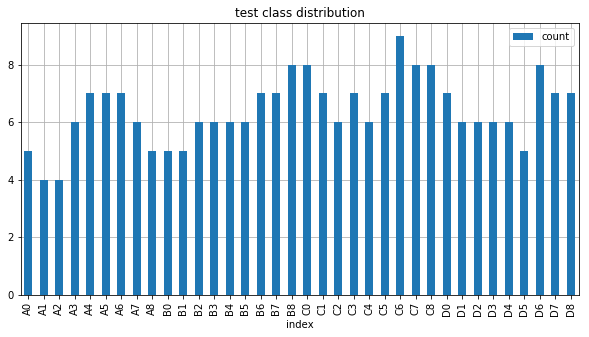

In [22]:
# Step 5.3 
pd.DataFrame(pd.Series(y_test).value_counts(),columns=["count"]).reset_index().sort_values("index").set_index("index").plot(kind="bar",
        grid=True,figsize=(10,5),title="test class distribution",zorder=10)


 ---
 ## Grid searchCV on Random Forest Classifier

In [23]:
# Step 6
from sklearn.model_selection import GridSearchCV

title="Grid searchCV on Random Forest Classifier"                                                      # set title
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [ 100, 110, 120, 130],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [2, 3, 4, 5, 6, ],
    'n_estimators': [500, 600, 700, 800]
}

# Create a based model
model = RandomForestClassifier()
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 3, return_train_score=True)
grid_search.fit(X_train, y_train)
display(HTML(f"<h2>{title} {grid_search.cv_results_['mean_test_score'][grid_search.cv_results_['rank_test_score'].argmin()]:7.3f}% with {grid_search.best_params_['n_estimators']} estimators(Trees)</h2>"))
display(HTML(f"<h3>Best params</h3>"))
for k in grid_search.best_params_ :
    print( f"Param {k:17} = {grid_search.best_params_[k]}")

Fitting 3 folds for each of 640 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1536 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  6.0min finished
C:\Users\tralore\Anaconda3\envs\exts-ml\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Param bootstrap         = False
Param max_depth         = 130
Param max_features      = 3
Param min_samples_leaf  = 1
Param min_samples_split = 3
Param n_estimators      = 800


In [24]:
# Step 6.1
y_predicted=grid_search.best_estimator_.predict(X_test)                                                                       # do predictions
cnt=0                                                                                                  # initialize counter
for j, predict in enumerate(y_predicted):                                                              # enmuerate results
    if predict != y_test[j]:                                                                           # check if successful
        cnt=cnt+1                                                                                      # increase errors
        print(f"predicted was {predict} but in reality it was {y_test[j]}")                            # print wrong prediction
print(f"{cnt} wrong out of {j} = {100/j*cnt:7.3f}%")                                                   # print summary

predicted was B3 but in reality it was B2
predicted was B3 but in reality it was B2
predicted was B0 but in reality it was B1
predicted was D3 but in reality it was D2
predicted was C0 but in reality it was C1
predicted was A3 but in reality it was A2
predicted was B3 but in reality it was B2
predicted was A2 but in reality it was A3
predicted was B3 but in reality it was B2
9 wrong out of 230 =   3.913%


In [25]:
# Step 6.2 
import sklearn.metrics

pd.options.display.max_columns = None                                                                  # disable column hiding
display(HTML("<h3>Confusion Matrix</h3>"))                                                             # print title

y_true = y_test                                                                                        # get data
y_pred = y_predicted                                                                                   # get data
newColumn=[]                                                                                           # initialize

r = sklearn.metrics.confusion_matrix(y_true, y_pred)                                                   # get confusion matrix
cmDf=pd.DataFrame(r.astype("O"))                                                                       # as string type
cmDf=cmDf.replace(0,".")                                                                               # for better visualizing replace 0 with .
for card in js.JassCN2._member_names_:                                                                 # make nice column names
    newColumn=newColumn+[card]                                                                         # next Card Id to column
cmDf.columns=newColumn                                                                                 # apply new column names
cmDf                                                                                                   # display dataframe and set column header
cmDf.style.set_table_styles(
    [dict(selector="th",props=[('max-width', '10px')]),
        dict(selector="th.col_heading",
                 props=[("writing-mode", "vertical-rl"), 
                        ('transform', 'rotateZ(-90deg)'),
                        ])])

In [26]:
import winsound                                              # signalize accepted prediction
duration = 1500                                              # milliseconds
freq = 1440                                                  # Hz
winsound.Beep(freq, duration)  

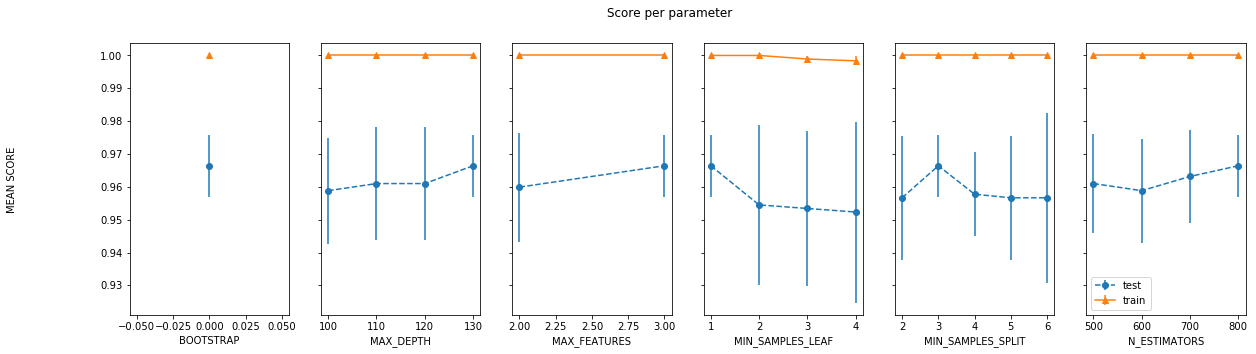

In [27]:
# Step 6.3
# code from stackoverflow
# https://stackoverflow.com/a/57013458
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()
display(HTML("<h3>Hyperparameter Score chart</h3>"))   
plot_search_results(grid_search)

## Best Performance

Do list the best results on all ever taken ML tasks, I'm going to iterate through all ML*.csv results and add them to a big result table. Results from the datascan_iii set I skip, as I do not use the mobile phone at the end for the scan procedure. The added results are identified by the file date and the source file name. This identifies the parameter that have been used to generate the appropriate result entry.


In [28]:
import os
import time
path=r"."
dr=pd.DataFrame()
fileList = [os.path.join(dp, f) for dp, dn, filenames in os.walk(path) for f in filenames if (os.path.splitext(f)[1] == '.csv' 
                                    and os.path.split(f)[1].startswith("ML") and not os.path.split(f)[1].endswith("iii.csv"))]
for file in fileList:
    temp=pd.read_csv(file)
    temp["source"]=file
    temp["date"]=int(os.path.getmtime(file))
    temp['date'] = pd.to_datetime(temp['date'],unit='s')
    dr=dr.append(temp,sort=False)
dr.reset_index(drop=True, inplace=True)
dd=dr[dr["set"]== "test"].sort_values(["acc","loss"],ascending=[False,True])[["model","acc","loss","set","source","date"]]
dd.reset_index(drop=True, inplace=True)
dd.head(10)

model    acc   loss   set                  source                date
0   CNN64MA  0.998  0.008  test   .\ML_results_v_99.csv 2021-03-21 12:40:26
1    CNN224  0.998  0.009  test      .\ML_results_v.csv 2021-03-16 22:47:20
2    CNN224  0.998  0.009  test  .\ML_results_v_100.csv 2021-03-16 22:49:05
3     CNN64  0.998  0.010  test   .\ML_results_v_80.csv 2021-03-12 16:08:37
4     CNN64  0.998  0.010  test   .\ML_results_v_99.csv 2021-03-21 12:40:26
5    CNN224  0.998  0.011  test   .\ML_results_v_99.csv 2021-03-21 12:40:26
6   CNN64DG  0.997  0.013  test   .\ML_results_v_80.csv 2021-03-12 16:08:37
7    CNN224  0.997  0.014  test   .\ML_results_v_80.csv 2021-03-12 16:08:37
8   CNN64DG  0.997  0.014  test   .\ML_results_v_99.csv 2021-03-21 12:40:26
9  CNN224DG  0.997  0.014  test   .\ML_results_v_99.csv 2021-03-21 12:40:26

---
# Frontend

<table style="border: solid #fff;">
<!--  Website to generate base63 stream : https://www.base64-image.de/
-->    
    <tr style="vertical-align:top"><td style="vertical-align:top">
        <p style="font-size: 110%;">On the right you see the screenshot during the card drop process in action.</p>
        <ol>
        <li style="font-size: 110%;">The Frame window shows in general the current scanned image</li>
        <li style="font-size: 110%;">The light green shows the boundingbox and the biggest found contour</li>
        <li style="font-size: 110%;">The trackbars rr, gg, bb allows some calibration for red, green and blue color channel. The value 127 is th center for the correction</li>
        <li style="font-size: 110%;">Within the frame window you can see the current predicted card name</li>        
        <li style="font-size: 110%;">Within the frame window you can see the current chosen mode and also the summarized score value</li>
        <li style="font-size: 110%;">The mask window shows the current mask that will be applied to the frame</li>
        <li style="font-size: 110%;">The mask window shows the trackbar for the threshold value that will be used</li>
        <li style="font-size: 110%;">The combined window shows the combination of calibrated image, with applied mask and deep black background</li>
        <li style="font-size: 110%;">The small ml window shows the image which is going to be used on the machine learning algorithm, It has the needed input size of the current algorithm and is cropped. You can also see that surrounding black parts have been changed by the current diffuser settings</li>
        </ol>
        </td>
        <td>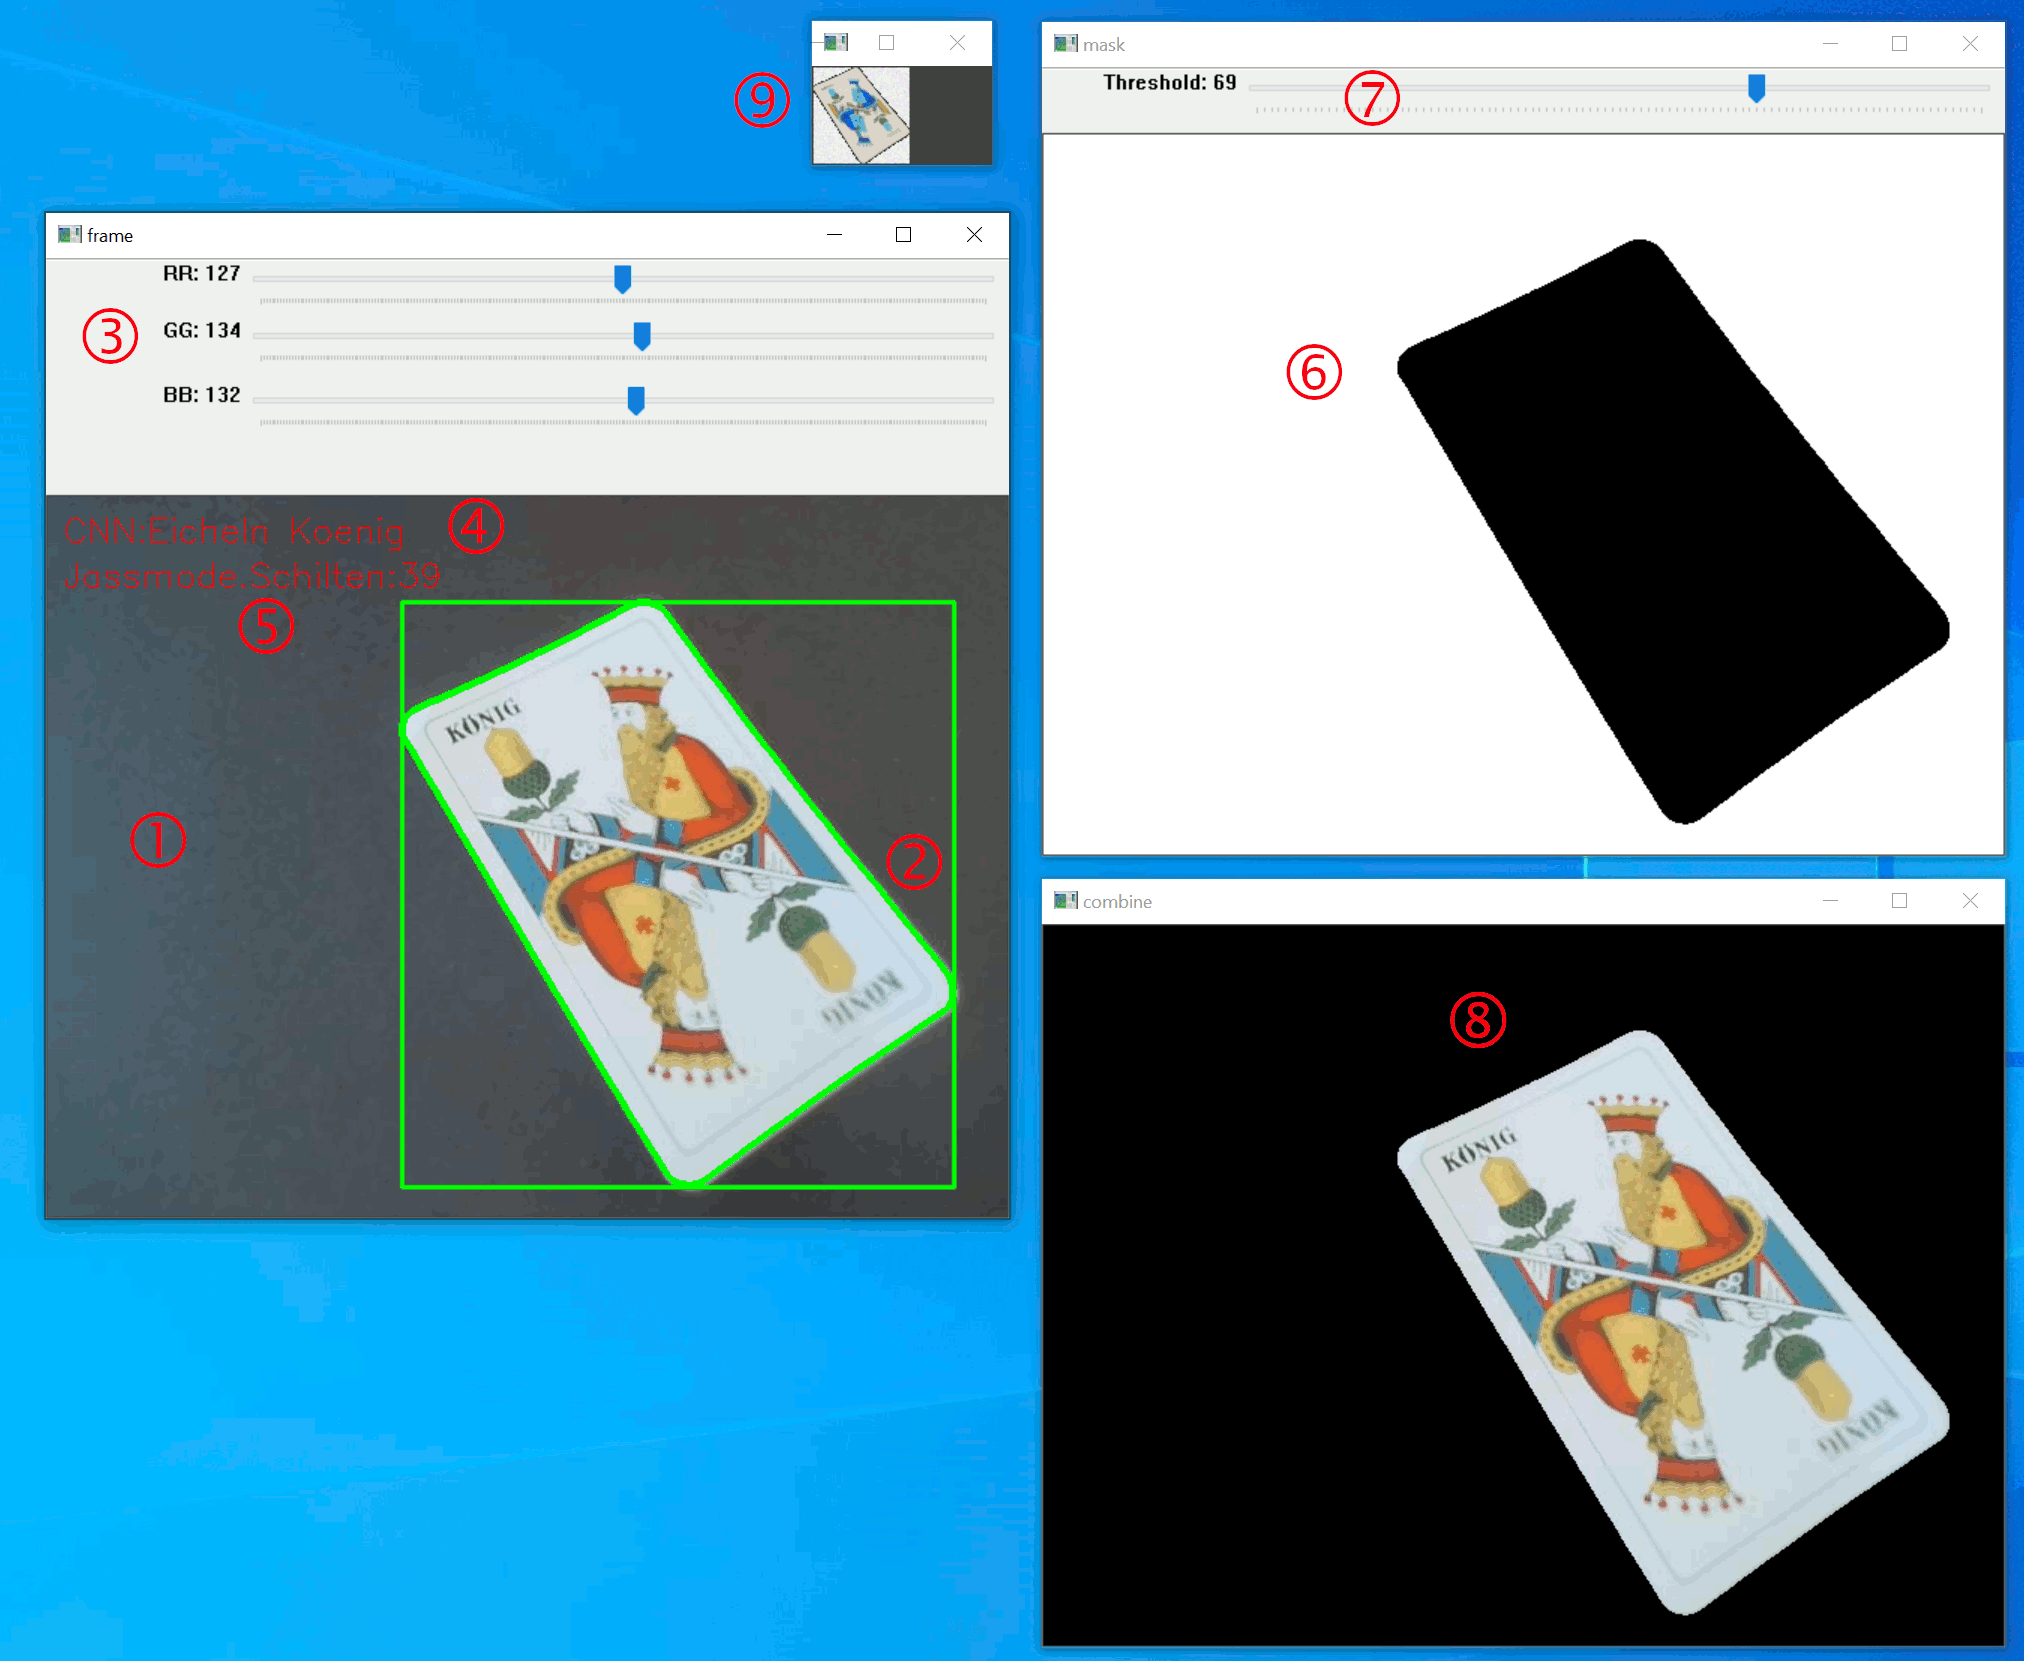</td>
    </tr></table>

In [29]:
import JassSummarizer as js
from enum import Enum
from PIL import Image
import matplotlib.pyplot as plt 
from IPython.core.display import display, HTML
import json
from tqdm import tqdm
import numpy as np
import pandas as pd
import random
import time
import re
import cv2
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, InputLayer, Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
import tensorflow.keras as keras
import tensorflow as tf

from tensorflow.keras.models import Sequential,model_from_json
from PIL import Image

modelname="CIFA64_diffuser_model"                                                                  # name current model to use
modelname="CNN224MA_ii_99"
modelname="CNN64_iiiiiiv_40"
modelname="test64"
modelname="CNN224_iii_99"
modelname="CNN64DG_v_80"
path=os.path.join(r".\model_save",modelname)                                                       # generate path with modelname
json_file = open(path+'.json', 'r')                                                                # open model file
loaded_model_json = json_file.read()                                                               # load file
json_file.close()                                                                                  # close file
loaded_model = model_from_json(loaded_model_json)                                                  # convert json object
loaded_model.load_weights(path+".h5")                                                              # load weights
print(f"Loaded model '{modelname}' from disk")                                                     # print model name
model=loaded_model                                                                                 # use general model variable wich loaded 
mode=int(re.findall(r'\d+',modelname)[0])                                                          # find size of model
inputSize = (mode, mode)                                                                           # use founded size as inputSize
mlDimension = (mode,mode,3)                                                                        # also with color chanel dimension


Loaded model 'CNN64DG_v_80' from disk


### Mobilenet Pretrained Net model initialisation

In [30]:
# Step 2
img_graph = tf.Graph()                                                                             # Create graph
with img_graph.as_default():
    module_url = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2'         # library url
    feature_extractor = hub.Module(module_url)                                                     # Download module
    input_imgs = tf.placeholder(dtype=tf.float32, shape=[None, 224, 224, 3])                       # Create input placeholder
    imgs_features = feature_extractor(input_imgs)                                                  # A node with the features
    init_op = tf.group([tf.global_variables_initializer(), tf.tables_initializer()])               # Collect initializers
img_graph.finalize()                                                                               # Good practice: make the graph "read-only"

initialization_op = tf.global_variables_initializer()                                              # Init
sess = tf.Session(graph=img_graph)                                                                 # Create a session
sess.run(init_op)                                                                                  # Initialize it
#features = sess.run(imgs_features, feed_dict={input_imgs: img_batch})  

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


### Randomforest model activation

In [31]:
import sklearn.externals.joblib as joblib
rmfFilename=r".\model_save\RMF224PT_iii_40.joblib"                                                 # define name
rmfModel = joblib.load(rmfFilename)                                                                # load trained model from Jupyter Notebook 04_Machine_learning_03


### Frontend routine for prediction

In [32]:

def nothing(val):                                                       # empty funtion to handle trackbar
    pass
def calcK(x):
    return ((127-x)*0.01)+1.0

t_rescaled=0.4
threshold=47                                                            # variable for trackbar threshold
window_name_mask="mask"                                                 # Window title name set to mask
cv2.namedWindow(window_name_mask)                                       # activate Window                
trackbar_name = "Threshold"                                             # set trackbar name          
cv2.createTrackbar(trackbar_name, "mask" , threshold, 100, nothing)             # initiate window with range from 0 -100 for threshold
predictModel="CNN"                                                      # Selector for active predict model can be CNN or RMF

r=rr=rrr=g=gg=ggg=b=bb=bbb=127                                          # r g b calibration variable, currently only rr,gg,bb is used for correction
cv2.namedWindow('frame')                                                # the window has to be named for the trackbar identification
cv2.createTrackbar('RR','frame',rr,255,nothing)                         # get value correction for red chanel
cv2.createTrackbar('GG','frame',gg,255,nothing)                         # get value correction for green chanel
cv2.createTrackbar('BB','frame',bb,255,nothing)                         # get value correction for blue chanel

# initilizing vars needed during webcam loop
savePrediction=lastPrediction=""                                        # prediction vars to validate successfull prediction behin each other
cardScore = cnt = 0                                                     # cardScore counter
jassMode = mlData2 = None                                               # has to be initialized to none, because mostly the first scan has no contours

cap = cv2.VideoCapture(0)                                               # webcam capture method 0 primary cam, 1 secondary cam
while(1):                                                               # loop until esc key
    # Take each frame
    _, frameData = cap.read()                                               # take frame
    
    rr = cv2.getTrackbarPos('RR','frame')                               # read current trackbar value for red
    gg = cv2.getTrackbarPos('GG','frame')                               # read current trackbar value for green
    bb = cv2.getTrackbarPos('BB','frame')                               # read current trackbar value for blue
    t_rescaled=cv2.getTrackbarPos(trackbar_name,'mask')*0.01            # read current trackbar value for threshold
    
    frameCalib=frameData.copy()
    frame=(frameCalib*([calcK(rr),calcK(gg),calcK(bb)])).astype("uint8")
    
    frameOrg,mask,img_rect,res,crop_img,d = js.analyzeScan(frame,t_rescaled)       # analyze image and receive diffrent result images including boundingbox dimension
    x,y,w,h = d                                                         # needed to find out if there have been contours in the analyzeScan operation
    
    if (w!=0 and h!=0):                                                 # if no contours are there we do not need to analyze something  
        rgb = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)                 # color channel switch to RGB
        mlData1=cv2.resize(rgb, inputSize , interpolation = cv2.INTER_AREA)
        mlData2=js.backgroundDiffuser3(mlData1,10)                      # change black regions with backgroundDiffuserX function
        mlData2=mlData1                                                 # may undo backgroundDiffuserX
        #tst=[]                                                          
        mlData3=mlData2/255                                             # normalize
        scan=np.expand_dims(mlData3,axis=0)                             # add dimension for multiple prediction
        if predictModel == "RMF":                                       # check which predictionModel is active
            features = sess.run(imgs_features, feed_dict={input_imgs: scan})
            rmfPredict=rmfModel.predict(features)                       # get predicted label
            scoreId=js.JassCN2[rmfPredict[0]].value                     # get number from label
        else:                                                           # CNN mode
            score = model.predict(scan)                                 # get score array
            scoreId=score.argmax()                                      # get best score
        theCardText=js.jassCardName(js.JassCN2(scoreId).name)           # generate caredname from CardId
    else:
        theCardText=""                                                  # empty cardtext when no boundingbox is available
    
    # Display Textinformation within image
    #img_rect=cv2.putText(np.array(img_rect),theCardText, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.75, [0,0,255])
    #img_rect=cv2.putText(np.array(img_rect),str(savePrediction), (10,60), cv2.FONT_HERSHEY_SIMPLEX, 0.75, [0,0,255])
    img_rect=cv2.putText(np.array(img_rect),f"{predictModel}:{lastPrediction}", (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.75, [0,0,255])
    img_rect=cv2.putText(np.array(img_rect),f"{jassMode}:{cardScore}", (10,60), cv2.FONT_HERSHEY_SIMPLEX, 0.75, [0,0,255])
    
    if mlData2 is not None:                                              # check if prediction is available
        cv2.imshow('ml',mlData2)                                         # show imagedata that goes into model prediction
    cv2.imshow('combine',res)                                            # show combination os mask and image
    cv2.imshow('frame',img_rect)                                         # show what was scanned
    cv2.imshow(window_name_mask,np.array(mask))                          # show mask with slider
    
    k = cv2.waitKey(3) & 0xFF                                            # wait for keystroke or continue after 3 milliseconds
    
    if lastPrediction==theCardText and theCardText!="":                  # check if there is a prediction made and if the current is equal to the last
        cnt=cnt+1                                                        # count identical predictions
        if cnt>11 and lastPrediction!=savePrediction:                    # if equal prediction count > 11 it counts as valid
            savePrediction=lastPrediction                                # update last validated prediction
            import winsound                                              # signalize accepted prediction
            duration = 30                                                # milliseconds
            freq = 1440                                                  # Hz
            winsound.Beep(freq, duration)                                # os function for sound play
            card=js.JassCN2(score.argmax()).name                         # get score
            if jassMode is not None:                                     # calculate if jassMode ist set
                cardScore = cardScore + (js.calculateScore(card,jassMode))
    else:
        cnt=0                                                            # reset count if there was another prediction then the last
    lastPrediction=theCardText                                           # update text
            
    if k==49:      # 1
        cardScore=0; jassMode=js.Jassmode.Eicheln
    if k==50:      # 2
        cardScore=0; jassMode=js.Jassmode.Schellen
    if k==51:      # 3
        cardScore=0; jassMode=js.Jassmode.Schilten
    if k==52:      # 4
        cardScore=0; jassMode=js.Jassmode.Rosen
    if k==53:      # 5
        cardScore=0; jassMode=js.Jassmode.Topdown    
    if k==54:      # 6
        cardScore=0; jassMode=js.Jassmode.Downup         
    if k == 32:      # Space
        cardScore=0
    if k == 48:      # 0 => switch to RMF pretrained mode
        inputSize=(224,224)
        predictModel="RMF"
    if k == 27:                                                           # Escape key check for exit
        myImg=Image.fromarray(mlData2)
        myImg.save("last.jpg")
        break
        
cv2.destroyAllWindows()

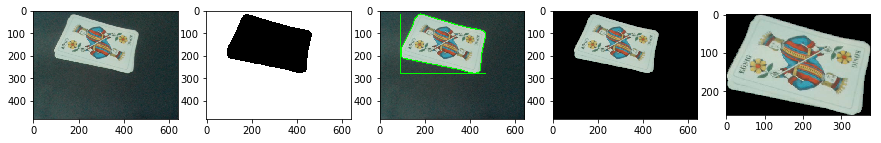

In [33]:
visualCheck= True
if visualCheck:
    data=js.analyzeScan(frameOrg)
    display(HTML("<h1>analyzeImage result check"))
    fig=plt.figure(figsize=(15,15))
    i=col=1
    for item in data[0:-1]:
        temp=cv2.cvtColor(item,cv2.COLOR_BGR2RGB)
        fig.add_subplot(1, 5, i)
        plt.imshow(temp)
        i=i+1
    plt.show()

## Improvement possibilities


* adding color information into CNN model (not as flatten values but as separated input)
* trying to count the distinct pattern for Eicheln, Schellen, Schilten und Rosen sujets in the image
* trying othe layer configuration on the CNN (also versions which are not supported on my GPU because of the limited Memory)
  * VGG16 
  * ResNet
  * individual settings on the CNN layers and activations
  
 